In [150]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (10, 6) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

!pip install --upgrade scikit-learn==1.3.2 -q

import sklearn
sklearn.set_config(transform_output="pandas")
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import PredictionErrorDisplay
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import TargetEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SequentialFeatureSelector
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.inspection import PartialDependenceDisplay

In [151]:
!pip install --upgrade shap==0.44.1 -q
import shap
shap.initjs()

In [152]:
data = pd.read_csv("Adverts.csv")

In [153]:
data.head(5)

public_reference   mileage reg_code standard_colour standard_make  \
0   202006039777689       0.0      NaN            Grey         Volvo   
1   202007020778260  108230.0       61            Blue        Jaguar   
2   202007020778474    7800.0       17            Grey         SKODA   
3   202007080986776   45000.0       16           Brown      Vauxhall   
4   202007161321269   64000.0       64            Grey    Land Rover   

      standard_model vehicle_condition  year_of_registration  price  \
0               XC90               NEW                   NaN  73970   
1                 XF              USED                2011.0   7000   
2               Yeti              USED                2017.0  14000   
3              Mokka              USED                2016.0   7995   
4  Range Rover Sport              USED                2015.0  26995   

   body_type  crossover_car_and_van              fuel_type  
0        SUV                  False  Petrol Plug-in Hybrid  
1     Saloon                  False                 Diesel  
2        SUV                  False                 Petrol  
3  Hatchback                  False                 Diesel  
4        SUV                  False                 Diesel

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [155]:
data.drop(['public_reference', 'price'], axis=1).describe()

mileage  year_of_registration
count  401878.000000         368694.000000
mean    37743.595656           2015.006206
std     34831.724018              7.962667
min         0.000000            999.000000
25%     10481.000000           2013.000000
50%     28629.500000           2016.000000
75%     56875.750000           2018.000000
max    999999.000000           2020.000000

In [156]:
data.describe(include='object')

reg_code standard_colour standard_make standard_model  \
count    370148          396627        402005         402005   
unique       72              22           110           1168   
top          17           Black           BMW           Golf   
freq      36738           86287         37376          11583   

       vehicle_condition  body_type fuel_type  
count             402005     401168    401404  
unique                 2         16         9  
top                 USED  Hatchback    Petrol  
freq              370756     167315    216929

In [157]:
correlation_matrix = data.drop(['public_reference'], axis=1).corr(numeric_only = True)
correlation_matrix['price'].sort_values(ascending=False)

price                    1.000000
year_of_registration     0.102341
crossover_car_and_van    0.010402
mileage                 -0.160204
Name: price, dtype: float64

In [158]:
def remove_outlier(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5 * IQR

    df = df[df[column_name] <= upper_limit]
    return df

In [159]:
data = remove_outlier(data, 'mileage')
data = remove_outlier(data, 'price')

In [160]:
data = data[data['year_of_registration'] > 1975]

In [161]:
def fill_missing(df, column_name):
    mode_value = df[column_name].mode()[0]
    
    df[column_name] = df[column_name].fillna(mode_value)
    
    return df

In [162]:
data = fill_missing(data, 'fuel_type')
data = fill_missing(data, 'body_type')
data = fill_missing(data, 'standard_colour')

In [163]:
def box_plot(data, column, width=0.5, palette='cividis'):

    sns.boxplot(x=column, data=data, width=width, palette=palette)

    plt.xlabel(column.capitalize(), fontsize=14)
    plt.xticks(ha='right')
    plt.ylabel('')
    plt.title(f'Distribution of {column.capitalize()}', fontsize=16)

    plt.show()

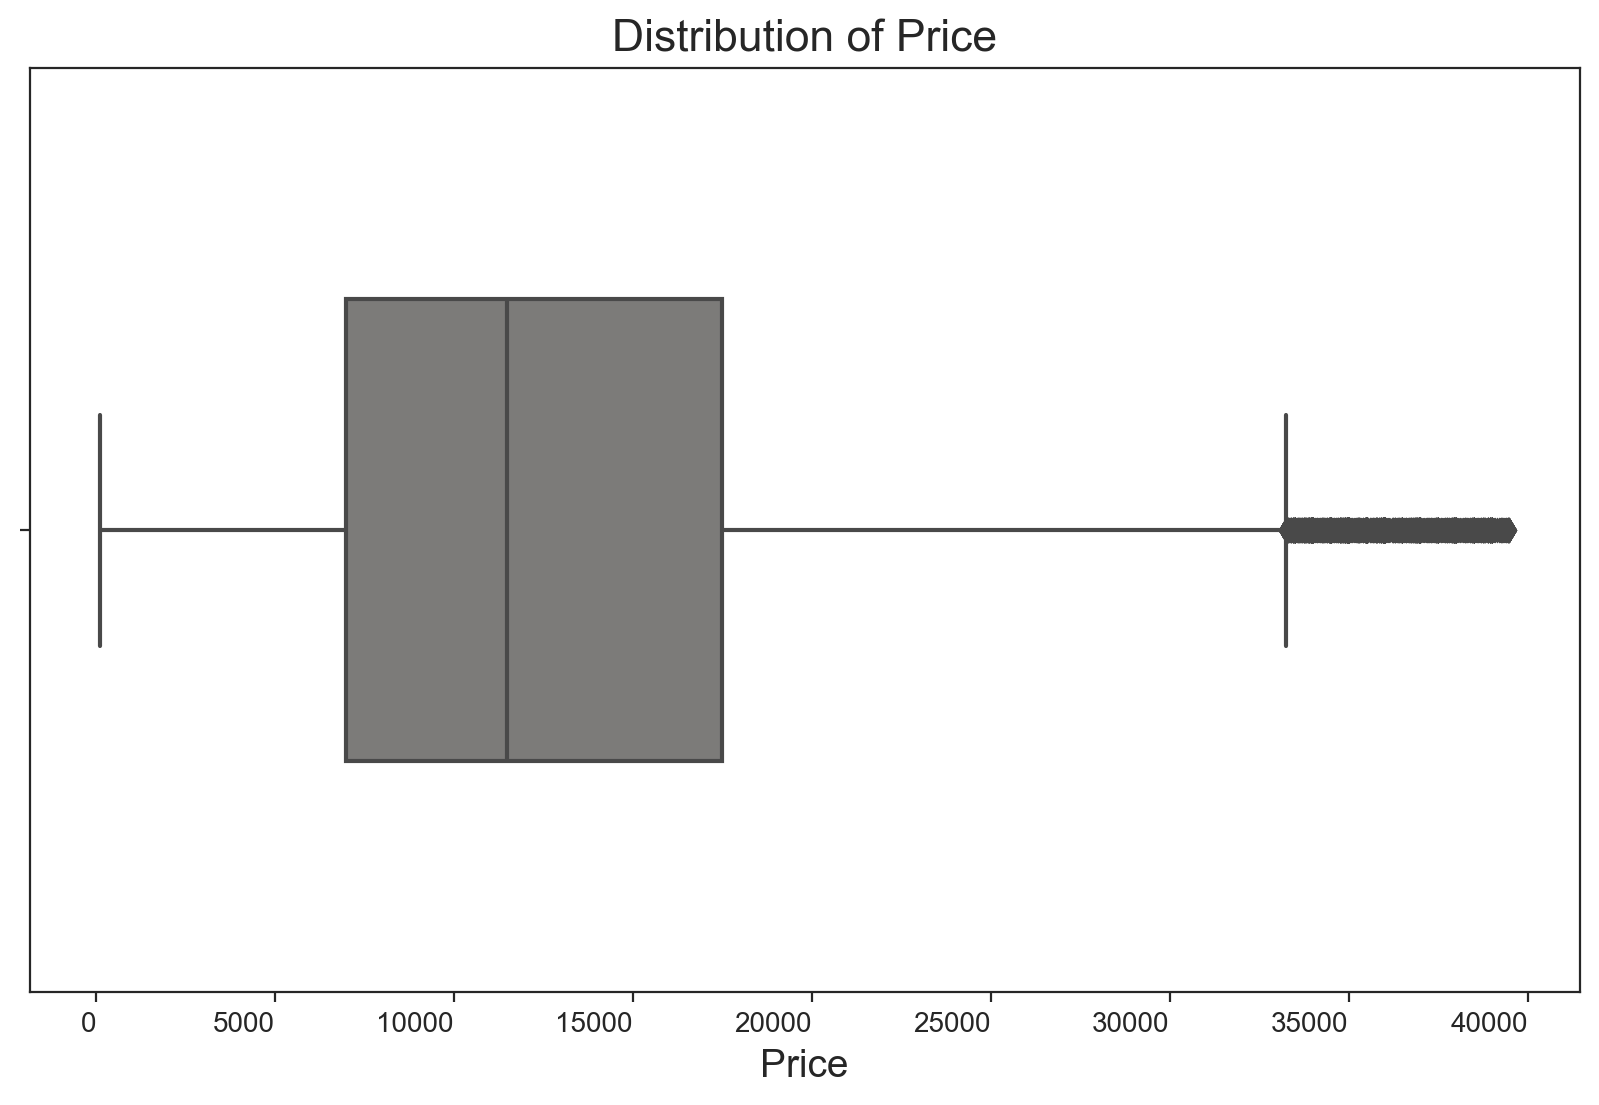

In [164]:
box_plot(data, 'price')

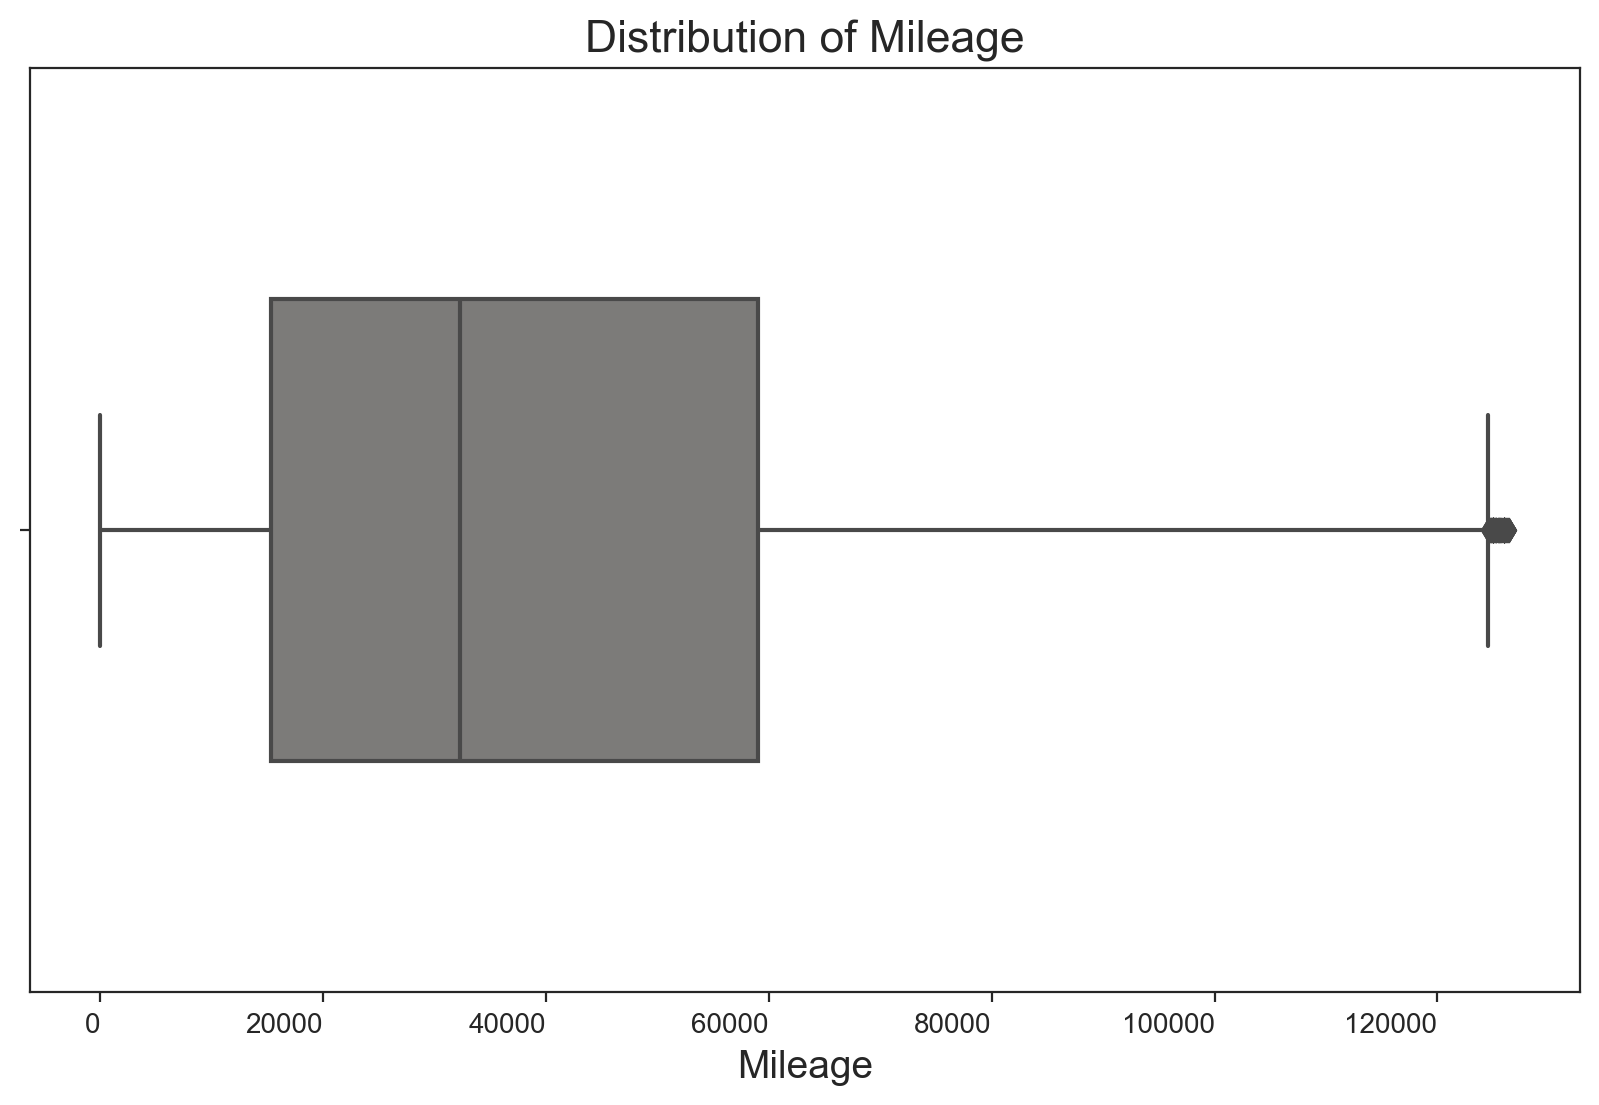

In [165]:
box_plot(data, 'mileage')

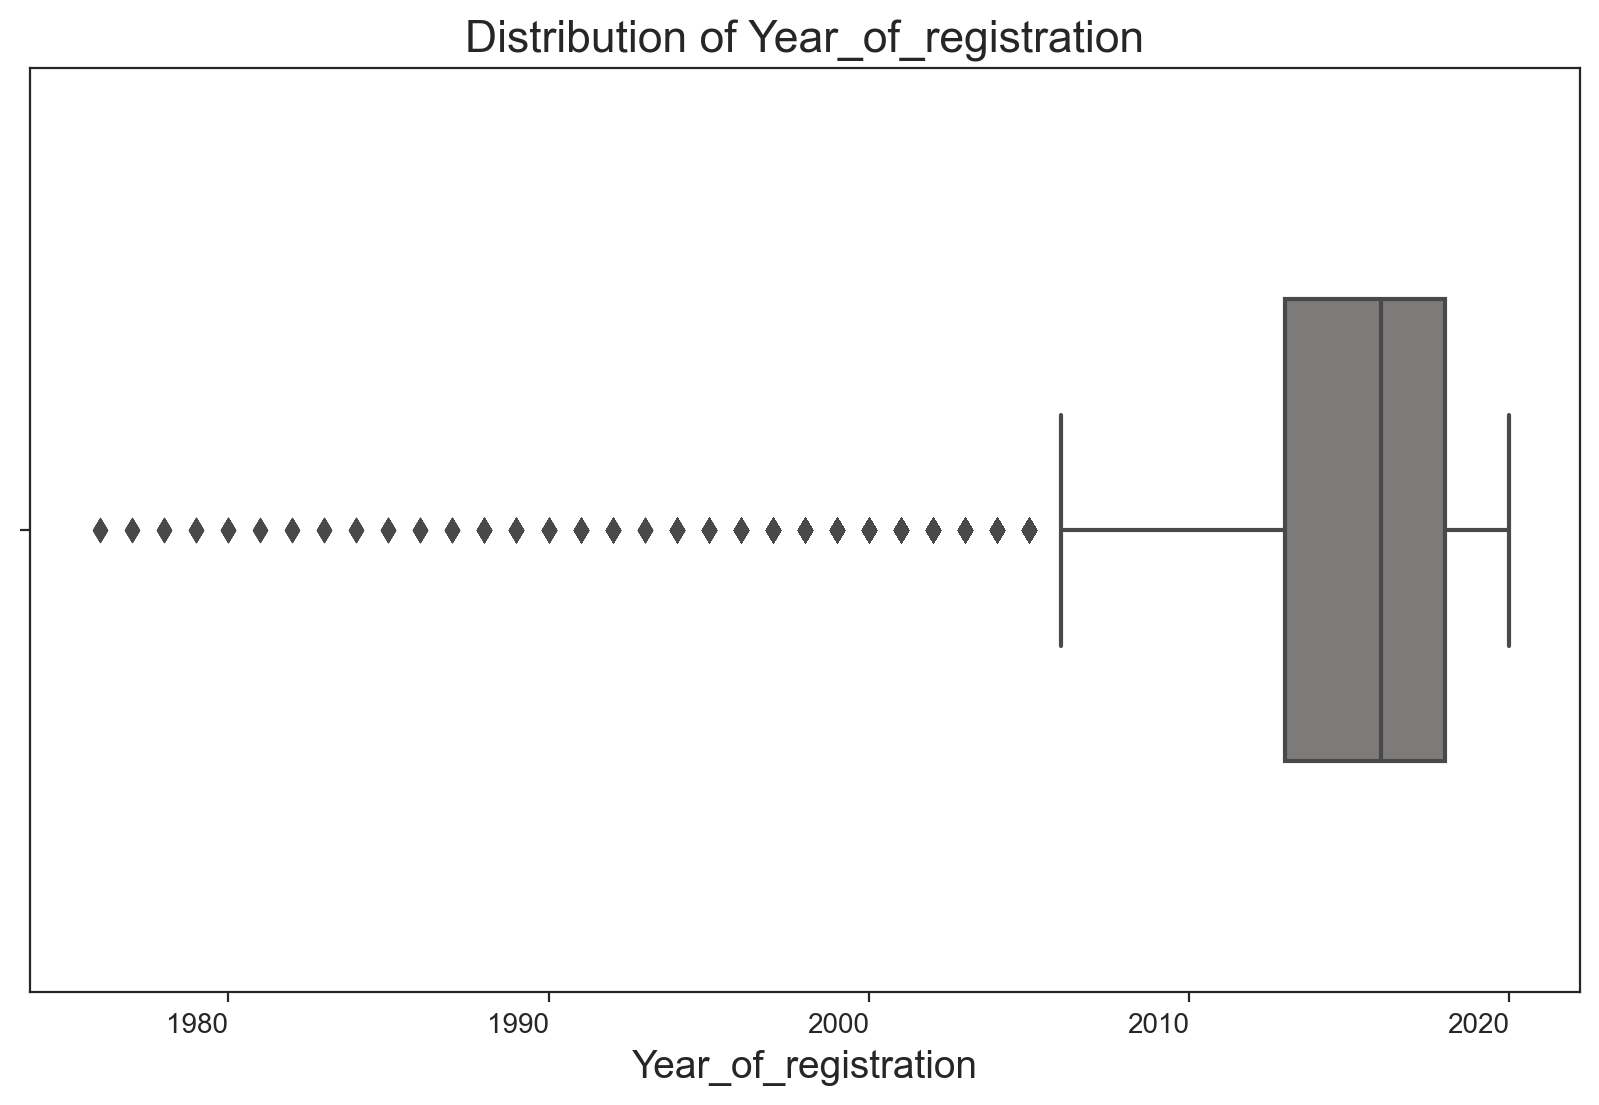

In [166]:
box_plot(data, 'year_of_registration')

In [167]:
data['vehicle_age'] = 2024 - data['year_of_registration']
data['mileage_to_age_ratio'] = data['mileage'] / data['vehicle_age']

data[['vehicle_age', 'mileage_to_age_ratio']].tail(5)

vehicle_age  mileage_to_age_ratio
402000          5.0           1035.800000
402001         15.0           7333.333333
402002         12.0           4396.666667
402003          9.0           1138.888889
402004         10.0           1400.000000

In [168]:
def feature_selection(dataframe):
    numeric_features = []
    categorical_features = []

    for column in dataframe.columns:
        if dataframe[column].dtype in ['int64', 'float64']:
          numeric_features.append(column)
        else:
            categorical_features.append(column)

    return numeric_features, categorical_features

In [169]:
numeric_features, categorical_features = feature_selection(data)

numeric_features_to_remove = ['price', 'public_reference', 'year_of_registration']
categorical_features_to_remove = ['reg_code']

numeric_features = [feature for feature in numeric_features if feature not in numeric_features_to_remove]
categorical_features = [feature for feature in categorical_features if feature not in categorical_features_to_remove]

print("Updated Numeric Features:", numeric_features)
print("Categorical Features:", categorical_features)

Updated Numeric Features: ['mileage', 'vehicle_age', 'mileage_to_age_ratio']
Categorical Features: ['standard_colour', 'standard_make', 'standard_model', 'vehicle_condition', 'body_type', 'crossover_car_and_van', 'fuel_type']


In [170]:
X = data[numeric_features + categorical_features]
y = data['price']

y = y.loc[X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [171]:
def create_pipeline(est, X, linear_model=False, k_features= None, rfecv =False, sfs = False, use_pca=False,):
    """Creates a unified preprocessing and regression pipeline."""
    # Numeric pipeline
    numeric_steps = [("imputer", SimpleImputer(strategy="mean")),
                    ("scaler", MinMaxScaler())]
    if linear_model:
        numeric_steps.extend([
            ("poly", PolynomialFeatures(degree=3, include_bias=False))
        ])
    numeric_transformer = Pipeline(numeric_steps)

    # Categorical pipeline
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder(target_type='continuous').set_output(transform='pandas'))
    ])

    # Combine preprocessors
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ], remainder='passthrough', verbose_feature_names_out=False)

    steps = [("preprocessor", preprocessor)]
    
    if k_features:
        steps.append(("feature_selection", SelectKBest(f_regression,
                                                       k=k_features)))
    if rfecv:
        steps.append(("feature_selection", RFECV(estimator=est, 
                                                 step=1, cv=5)))
    if sfs:
        steps.append(("feature_selection", 
                      SequentialFeatureSelector(estimator=est, 
                                                n_features_to_select='auto', 
                                                direction="forward")))
    if use_pca:
        steps.append(("pca", PCA()))
    steps.append(("regressor", est))

    return Pipeline(steps)

In [172]:
pipeline = create_pipeline(LinearRegression(), X_train, linear_model=True)
pipeline.fit(X_train, y_train)
poly_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['poly']
feature_names = poly_transformer.get_feature_names_out()

print("Feature names:", feature_names)
print("\nNumber of features:", len(feature_names))

Feature names: ['mileage' 'vehicle_age' 'mileage_to_age_ratio' 'mileage^2'
 'mileage vehicle_age' 'mileage mileage_to_age_ratio' 'vehicle_age^2'
 'vehicle_age mileage_to_age_ratio' 'mileage_to_age_ratio^2' 'mileage^3'
 'mileage^2 vehicle_age' 'mileage^2 mileage_to_age_ratio'
 'mileage vehicle_age^2' 'mileage vehicle_age mileage_to_age_ratio'
 'mileage mileage_to_age_ratio^2' 'vehicle_age^3'
 'vehicle_age^2 mileage_to_age_ratio' 'vehicle_age mileage_to_age_ratio^2'
 'mileage_to_age_ratio^3']

Number of features: 19


In [ ]:
x_feature_index = 1
x_range = np.linspace(X_train.iloc[:, x_feature_index].min(), X_train.iloc[:, x_feature_index].max(), 1000)
x_pred_range = x_range.reshape(-1, 1)

fig, axs = plt.subplots(3, 3, figsize=(12, 8), constrained_layout=True)
lr_models = []
orders = [1, 2, 3, 4, 5, 6, 7, 9, 11]

for ax, order in zip(axs.ravel(), orders):
    model = make_pipeline(
        PolynomialFeatures(degree=order, include_bias=False),
        LinearRegression()
    )
    model.fit(X_train.iloc[:, [x_feature_index]], y_train)  
    lr_models.append(model)
    
    # Generate predictions for the range
    y_pred = model.predict(x_pred_range)
    
    ax.scatter(X_train.iloc[:, x_feature_index], y_train, alpha=0.3, marker='o', c='b', label='Training data')
    ax.scatter(X_test.iloc[:, x_feature_index], y_test, alpha=0.3, marker='s', c='r', label='Test data')
    ax.plot(x_range, y_pred, c='k', label='Model Prediction')
    ax.set_title(f'Degree {order}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Target')
    ax.legend()

# Print scores of models
for order, lr in zip(orders, lr_models):
    score = lr.score(X_test.iloc[:, [x_feature_index]], y_test)
    print(f"Score for degree {order}: {score}")

plt.show()

In [ ]:
pipeline_kbest = create_pipeline(est=LinearRegression(), X=X_train, linear_model=True, k_features = 10)
pipeline_rfecv = create_pipeline(est=LinearRegression(), X=X_train, linear_model=True, rfecv = True)
pipeline_sfs = create_pipeline(est=LinearRegression(), X=X_train, linear_model=True, sfs = True)

# Train and evaluate each pipeline
pipelines = {
    "SelectKBest": pipeline_kbest,
    "RFECV": pipeline_rfecv,
    "Sequential Feature Selection": pipeline_sfs
}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} pipeline score: {score}")

In [63]:
pipeline_kbest = create_pipeline(est=RandomForestRegressor(max_depth=10), X=X_train, k_features = 10)
pipeline_rfecv = create_pipeline(est=RandomForestRegressor(max_depth=10), X=X_train, rfecv = True)
pipeline_sfs = create_pipeline(est=RandomForestRegressor(max_depth=10), X=X_train, sfs = True)

# Train and evaluate each pipeline
pipelines = {
    "SelectKBest": pipeline_kbest,
    "RFECV": pipeline_rfecv,
    "Sequential Feature Selection": pipeline_sfs
}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} pipeline score: {score}")

SelectKBest pipeline score: 0.8233393998390904
RFECV pipeline score: 0.835572471303386
Sequential Feature Selection pipeline score: 0.8265622158137627


In [64]:
pipeline_kbest = create_pipeline(est=GradientBoostingRegressor(max_depth=7, learning_rate=0.2), X=X_train, k_features = 10)
pipeline_rfecv = create_pipeline(est=GradientBoostingRegressor(max_depth=7, learning_rate=0.2), X=X_train, rfecv = True)
pipeline_sfs = create_pipeline(est=GradientBoostingRegressor(max_depth=7, learning_rate=0.2), X=X_train, sfs = True)

# Train and evaluate each pipeline
pipelines = {
    "SelectKBest": pipeline_kbest,
    "RFECV": pipeline_rfecv,
    "Sequential Feature Selection": pipeline_sfs
}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} pipeline score: {score}")

SelectKBest pipeline score: 0.8343056246576613
RFECV pipeline score: 0.8380608871199444


KeyboardInterrupt: 

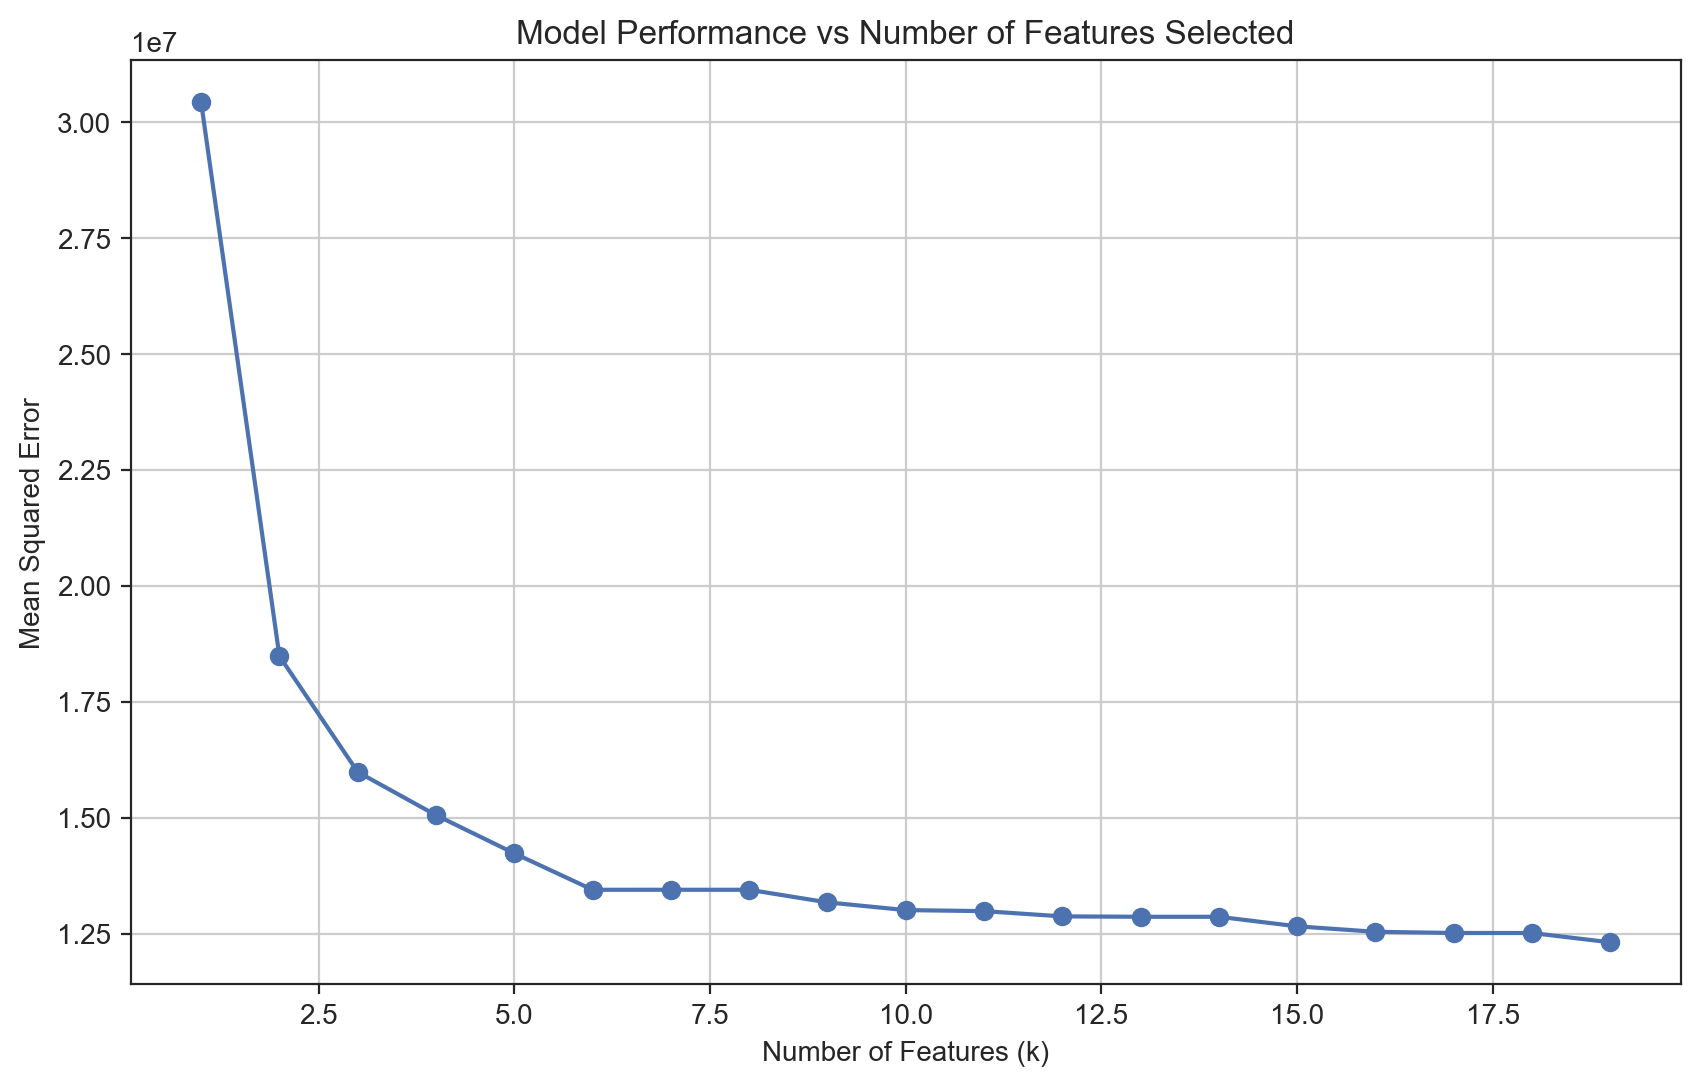

In [132]:
k_values = range(1, min(20, len(feature_names)) + 1)  

scores = []

for k in k_values:
    pipeline = create_pipeline(est=LinearRegression(), X=X_train, linear_model=True, use_pca=False, k_features=k)
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    scores.append(score)

# Plotting the results
plt.plot(k_values, scores, marker='o')
plt.xlabel('Number of Features (k)')
plt.ylabel('Mean Squared Error')
plt.title('Model Performance vs Number of Features Selected')
plt.grid(True)
plt.show()

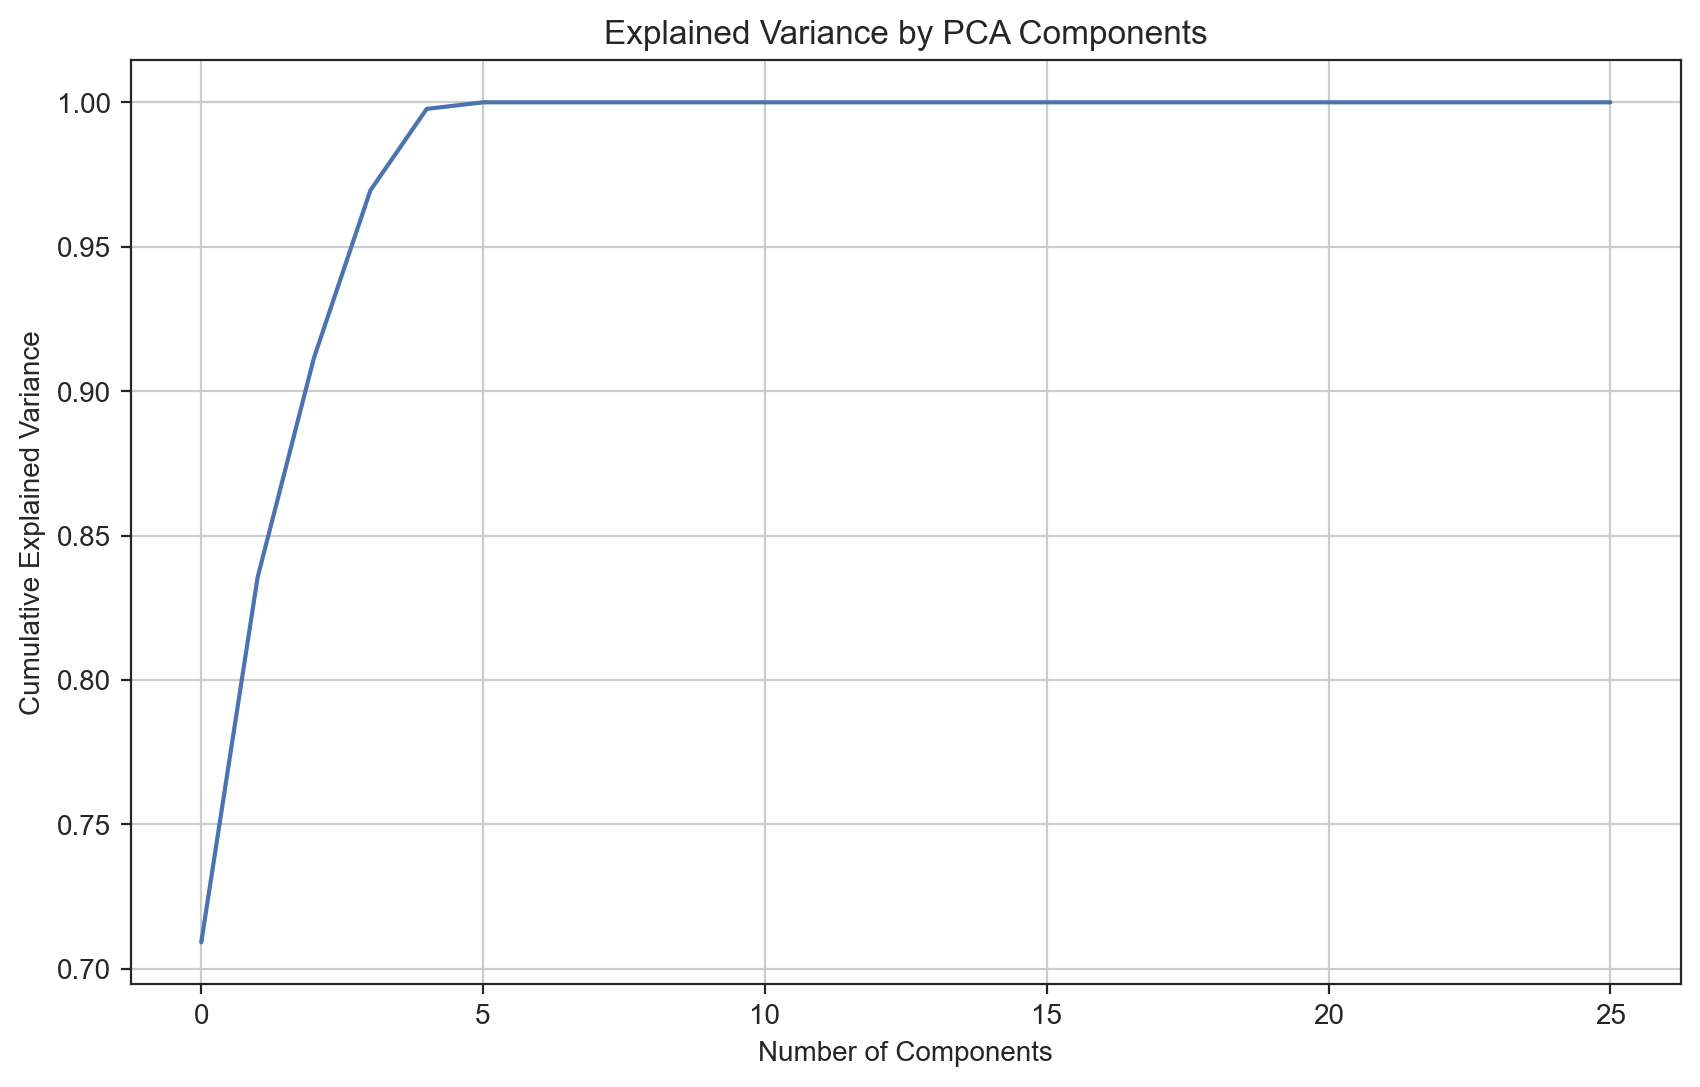

In [59]:
pipeline = create_pipeline(LinearRegression(), X_train, linear_model=True, use_pca=True)
pipeline.fit(X_train, y_train)

pca = pipeline.named_steps['pca']

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

In [29]:
lr = create_pipeline(LinearRegression(), X_train, linear_model=True, use_pca = True, k_features=10)
lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['mileage', 'vehicle_age',
                                                   'mileage_to_age_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'body_type',
                                                   'crossover_car_and_van',
                                                   'fuel_type'])],
                                   verbose_feature_names_out=False)),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x00000200F75F4D60>)),
                ('pca', PCA()), ('regressor', LinearRegression())])

In [28]:
lr_score_test = lr.score(X_test, y_test)
lr_score_train = lr.score(X_train, y_train)
y_pred = lr.predict(X_test)
lr_mae = mean_absolute_error(y_test, y_pred)

print("Linear Regression Train Score:", lr_score_train)
print("Linear Regression Test Score:", lr_score_test)
print("Mean Absolute Error:", lr_mae)

NameError: name 'lr' is not defined

In [136]:
def perform_grid_search(model, param_grid, X_train, y_train, cv=5):
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='neg_mean_absolute_error')
    grid_search.fit(X_train, y_train)
    return grid_search

In [22]:
rfr = create_pipeline(RandomForestRegressor(), X_train, use_pca = True, k_features= 10)
rfr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['mileage', 'vehicle_age',
                                                   'mileage_to_age_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'body_type',
                                                   'crossover_car_and_van',
                                                   'fuel_type'])],
                                   verbose_feature_names_out=False)),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x00000169660E4D60>)),
                ('pca', PCA()), ('regressor', RandomForestRegressor())])

In [23]:
rfr_score_test = rfr.score(X_test, y_test)
rfr_score_train = rfr.score(X_train, y_train)
y_pred = rfr.predict(X_test)
rfr_mae = mean_absolute_error(y_test, y_pred)

print("Random Forest Regressor Train Score:", rfr_score_train)
print("Random Forest Regressor Test Score:", rfr_score_test)
print("Mean Absolute Error:", rfr_mae)

Random Forest Regressor Train Score: 0.9568150728589216
Random Forest Regressor Test Score: 0.9239165347375908
Mean Absolute Error: 1453.803687989103


In [86]:
param_grid_rfr = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [5, 8, 10],
}

grid_search_rfr = perform_grid_search(create_pipeline(RandomForestRegressor(), X_train, 
                                                      use_pca = True, k_features= 10), 
                                      param_grid_rfr, X_train, y_train)

best_params_rfr = grid_search_rfr.best_params_

print("Best parameters:", best_params_rfr)

optimized_params_rfr = best_params_rfr

Best parameters: {'regressor__max_depth': 10, 'regressor__n_estimators': 200}


In [87]:
rfr_df = pd.DataFrame(grid_search_rfr.cv_results_)

selected_columns = [
    'param_regressor__n_estimators', 'param_regressor__max_depth',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]

rfr_df = rfr_df[selected_columns].sort_values('rank_test_score')
rfr_df

param_regressor__n_estimators param_regressor__max_depth  mean_test_score  \
7                           200                         10     -2402.878248   
8                           300                         10     -2404.695145   
6                           100                         10     -2413.768507   
5                           300                          8     -2438.418708   
3                           100                          8     -2441.963279   
4                           200                          8     -2442.442513   
0                           100                          5     -2671.908694   
1                           200                          5     -2682.562297   
2                           300                          5     -2688.157129   

   std_test_score  rank_test_score  
7       83.386851                1  
8       61.541543                2  
6       70.053262                3  
5       92.136983                4  
3       84.506878                5  
4       87.635157                6  
0       83.078754                7  
1       82.788958                8  
2       86.241285                9

In [24]:
gbr = create_pipeline(GradientBoostingRegressor(), X_train, use_pca = True, k_features= 10)
gbr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['mileage', 'vehicle_age',
                                                   'mileage_to_age_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   TargetEncoder(target_type='continuous'))]),
                                                  ['standard_colour',
                                                   'standard_make',
                                                   'standard_model',
                                                   'vehicle_condition',
                                                   'body_type',
                                                   'crossover_car_and_van',
                                                   'fuel_type'])],
                                   verbose_feature_names_out=False)),
                ('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x00000169660E4D60>)),
                ('pca', PCA()), ('regressor', GradientBoostingRegressor())])

In [25]:
gbr_score_test = gbr.score(X_test, y_test)
gbr_score_train = gbr.score(X_train, y_train)
y_pred = gbr.predict(X_test)
gbr_mae = mean_absolute_error(y_test, y_pred)

print("Gradient Boosting Regressor Train Score::", gbr_score_train)
print("Gradient Boosting Regressor Test Score::", gbr_score_test)
print("Mean Absolute Error:", gbr_mae)

Gradient Boosting Regressor Train Score:: 0.8627766597360396
Gradient Boosting Regressor Test Score:: 0.8618452123423991
Mean Absolute Error: 2074.1976714468437


In [85]:
param_grid_gbr = {
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
}

grid_search_gbr = perform_grid_search(create_pipeline(GradientBoostingRegressor(), X_train, use_pca = True, k_features= 10), param_grid_gbr, X_train, y_train)

best_params_gbr = grid_search_gbr.best_params_

print("Best parameters:", best_params_gbr)

optimized_params_gbr = best_params_gbr

Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 7}


In [88]:
gbr_df = pd.DataFrame(grid_search_gbr.cv_results_)

selected_columns = [
    'param_regressor__max_depth', 'param_regressor__learning_rate',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]

gbr_df = gbr_df[selected_columns].sort_values('rank_test_score')
gbr_df

param_regressor__max_depth param_regressor__learning_rate  mean_test_score  \
5                          7                            0.1     -2400.628142   
4                          5                            0.1     -2423.636026   
7                          5                            0.2     -2429.821516   
6                          3                            0.2     -2451.928139   
8                          7                            0.2     -2465.960884   
3                          3                            0.1     -2482.124629   
2                          7                           0.01     -3420.114288   
1                          5                           0.01     -3544.623483   
0                          3                           0.01     -3960.579698   

   std_test_score  rank_test_score  
5       90.510463                1  
4       50.137005                2  
7       85.948676                3  
6       77.174970                4  
8       55.875461                5  
3       91.091606                6  
2       98.055173                7  
1       96.791540                8  
0      101.016616                9

In [43]:
ensemble = VotingRegressor(
    [
        ("gbr", create_pipeline(GradientBoostingRegressor(max_depth=7, learning_rate=0.1), X_train, use_pca=True, k_features=10)),
        ("rfr", create_pipeline(RandomForestRegressor(max_depth=10, n_estimators=200), X_train, use_pca=True, k_features=10)),
        ('lr', create_pipeline(LinearRegression(), X_train, use_pca=True, k_features=10))
    ]
) 
ensemble.fit(X_train, y_train)

VotingRegressor(estimators=[('gbr',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['mileage',
                                                                                'vehicle_age',
                                                                                'mileage_to_age_ratio']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('encoder',
                                                                                                TargetEncode...
                                                                                               ('encoder',
                                                                                                TargetEncoder(target_type='continuous'))]),
                                                                               ['standard_colour',
                                                                                'standard_make',
                                                                                'standard_model',
                                                                                'vehicle_condition',
                                                                                'body_type',
                                                                                'crossover_car_and_van',
                                                                                'fuel_type'])],
                                                                verbose_feature_names_out=False)),
                                             ('feature_selection',
                                              SelectKBest(score_func=<function f_regression at 0x00000200F75F4D60>)),
                                             ('pca', PCA()),
                                             ('regressor',
                                              LinearRegression())]))])

In [36]:
vr_score_test = ensemble.score(X_test, y_test)
vr_score_train = ensemble.score(X_train, y_train)
y_pred = ensemble.predict(X_test)
vr_mae = mean_absolute_error(y_test, y_pred)

print("Voting Regressor Train Score::", vr_score_train)
print("Voting Regressor Test Score::", vr_score_test)
print("Mean Absolute Error:", vr_mae)

Voting Regressor Train Score:: 0.8917896612032807
Voting Regressor Test Score:: 0.8883158212377473
Mean Absolute Error: 1876.1182164714496


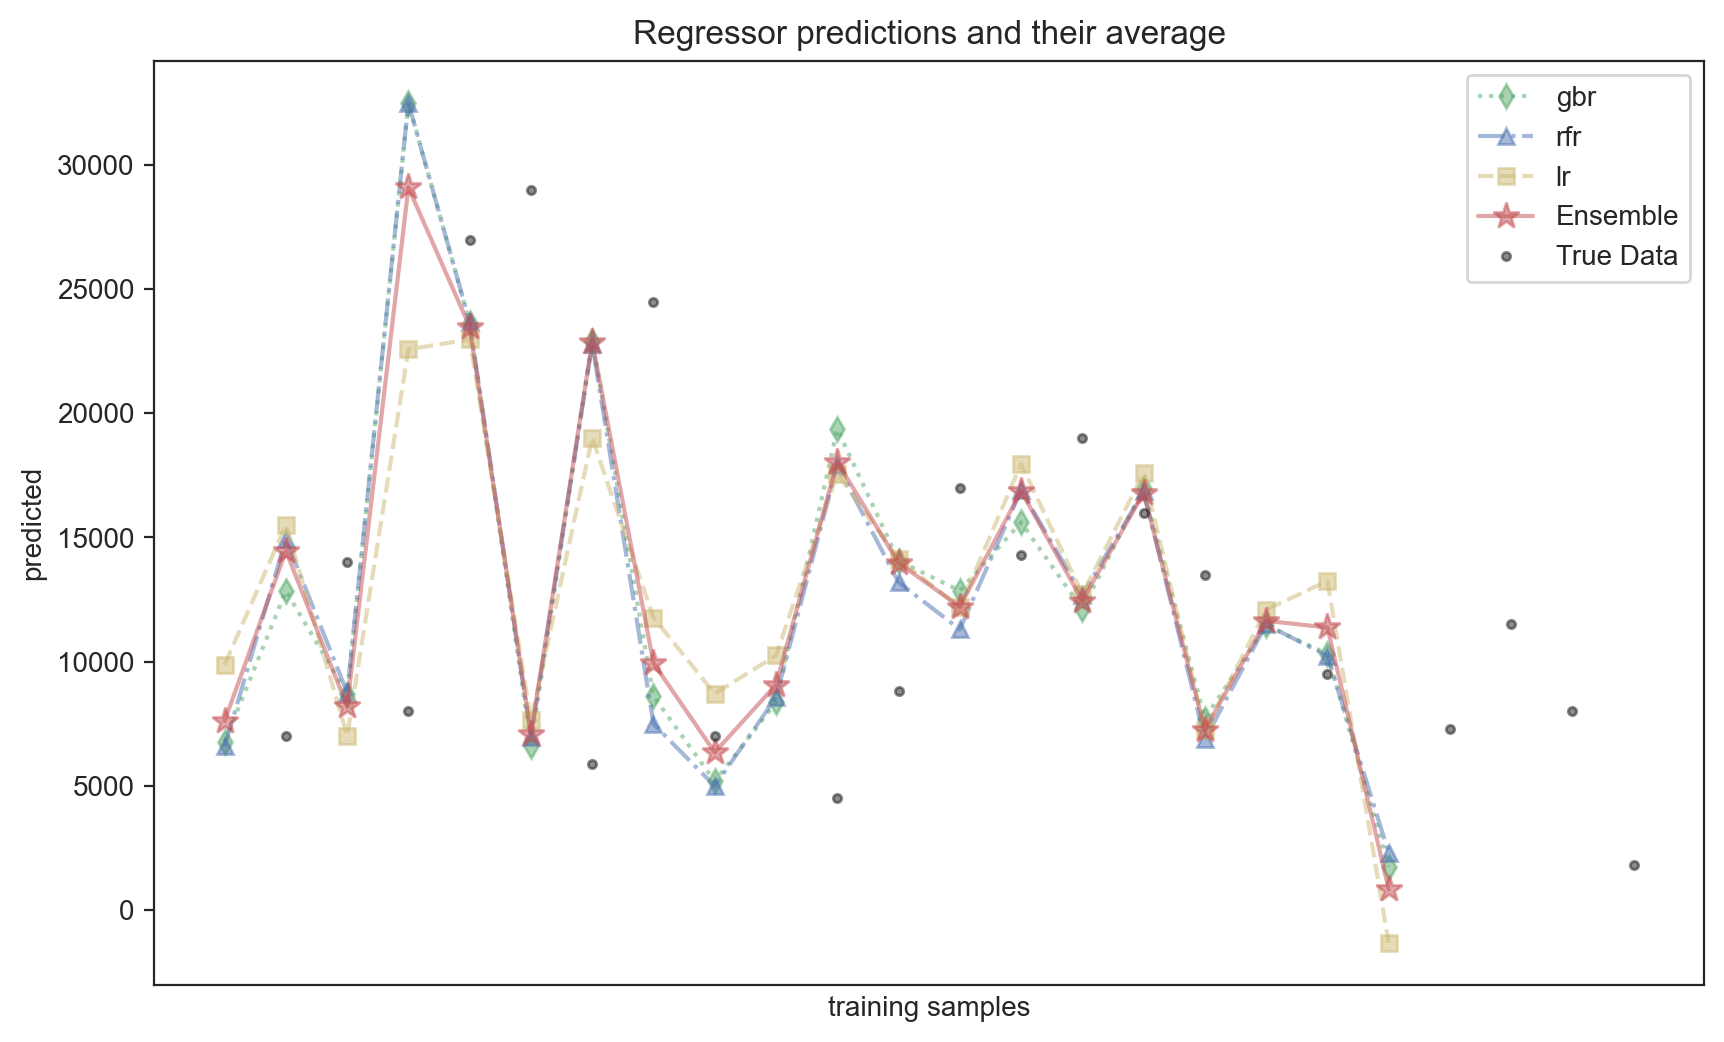

In [43]:
# Subset data
xt = X.head(20)
yt = y.head(20)

lr.fit(X_train, y_train)
rfr.fit(X_train, y_train)
gbr.fit(X_train, y_train)

# Predictions
pred_gbr = gbr.predict(xt)
pred_rfr = rfr.predict(xt)
pred_lr = lr.predict(xt)
pred_ens = ensemble.predict(xt)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(pred_gbr, "gd:", alpha=0.5, label="gbr")
ax.plot(pred_rfr, "b^-.", alpha=0.5, label="rfr")
ax.plot(pred_lr, "ys--", alpha=0.5, label="lr")
ax.plot(pred_ens, "r*-", alpha=0.5, ms=10, label="Ensemble")
ax.plot(yt, "ko", alpha=0.5, ms=3, label="True Data")

ax.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax.set_ylabel("predicted")
ax.set_xlabel("training samples")
ax.legend(loc="best")
ax.set_title("Regressor predictions and their average")

plt.show()

In [45]:
my_models = [
    create_pipeline(LinearRegression(), X_train, use_pca=True, k_features=10),
    create_pipeline(RandomForestRegressor(max_depth=10, n_estimators=200),X_train, use_pca=True, k_features=10),
    create_pipeline(GradientBoostingRegressor(max_depth=7, learning_rate=0.1), X_train, use_pca=True, k_features=10)
]

model_results_list = []
for my_model in my_models:
    eval_results = cross_validate(
        my_model, X, y, cv=5,
        scoring='neg_mean_absolute_error',
        return_train_score=True
    )
    model_results_list.append(
        (-eval_results['test_score'].mean(), eval_results['test_score'].std(),
         -eval_results['train_score'].mean(), eval_results['train_score'].std())
    )

In [46]:
model_results = pd.DataFrame(
    model_results_list,
    columns=['test_mae_mean', 'test_mae_std', 'train_mae_mean', 'train_mae_std'],
    index=['gbr', 'rfr', 'lr']
)

In [47]:
model_results

test_mae_mean  test_mae_std  train_mae_mean  train_mae_std
gbr    2742.151952      2.942566     2736.526226       0.412795
rfr    1831.165592      4.387861     1774.079606       6.174873
lr     1642.806390      7.906499     1586.302862      11.164612

In [48]:
eval_results = cross_validate(
    ensemble, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)
ensemble_result = (
    -eval_results['test_score'].mean(), eval_results['test_score'].std(),
    -eval_results['train_score'].mean(), eval_results['train_score'].std()
)

In [49]:
model_results.loc['ensemble'] = ensemble_result

In [50]:
model_results

test_mae_mean  test_mae_std  train_mae_mean  train_mae_std
gbr         2742.151952      2.942566     2736.526226       0.412795
rfr         1831.165592      4.387861     1774.079606       6.174873
lr          1642.806390      7.906499     1586.302862      11.164612
ensemble    1893.967528      2.772308     1856.971357       0.030252

###### 

In [61]:
lr = create_pipeline(LinearRegression(), X_train, use_pca=True, k_features=10)
rfr = create_pipeline(RandomForestRegressor(max_depth=10, n_estimators=200),X_train, use_pca=True, k_features=10)
gbr = create_pipeline(GradientBoostingRegressor(max_depth=7, learning_rate=0.1), X_train, use_pca=True, k_features=10)

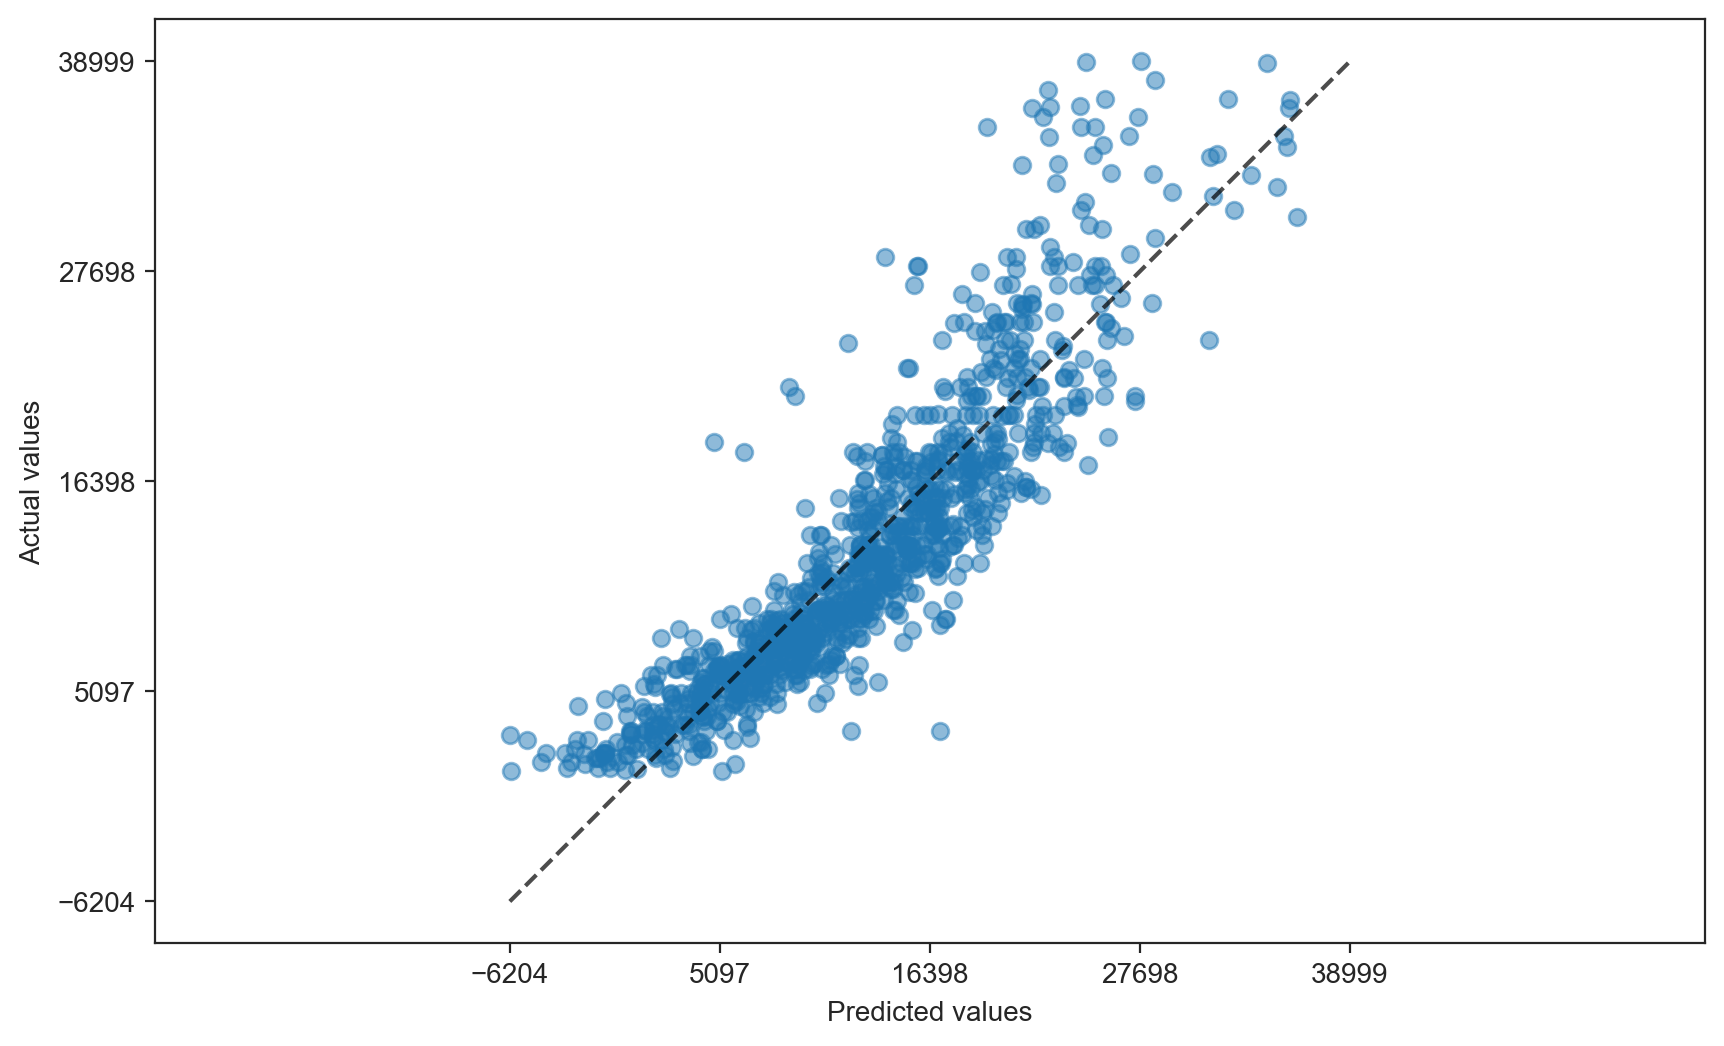

In [39]:
PredictionErrorDisplay.from_estimator(
    lr.fit(X_train, y_train), X_test, y_test, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
);

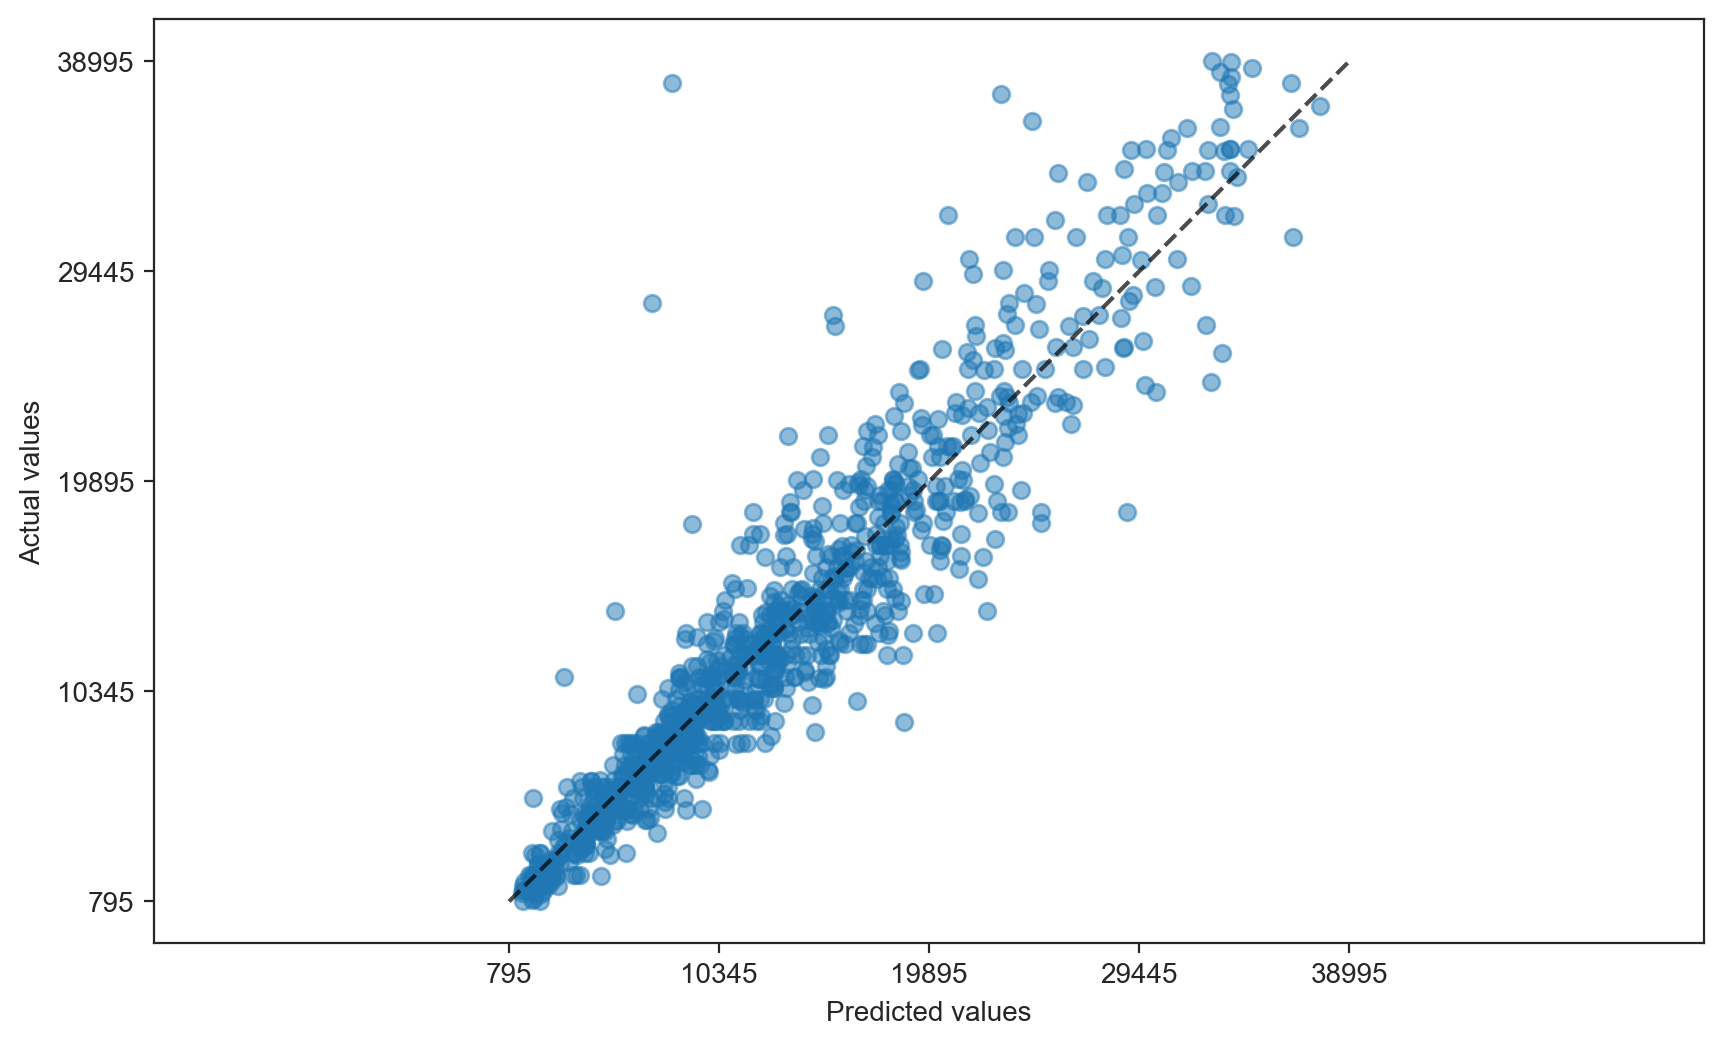

In [40]:
PredictionErrorDisplay.from_estimator(
    rfr.fit(X_train, y_train), X_test, y_test, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
)

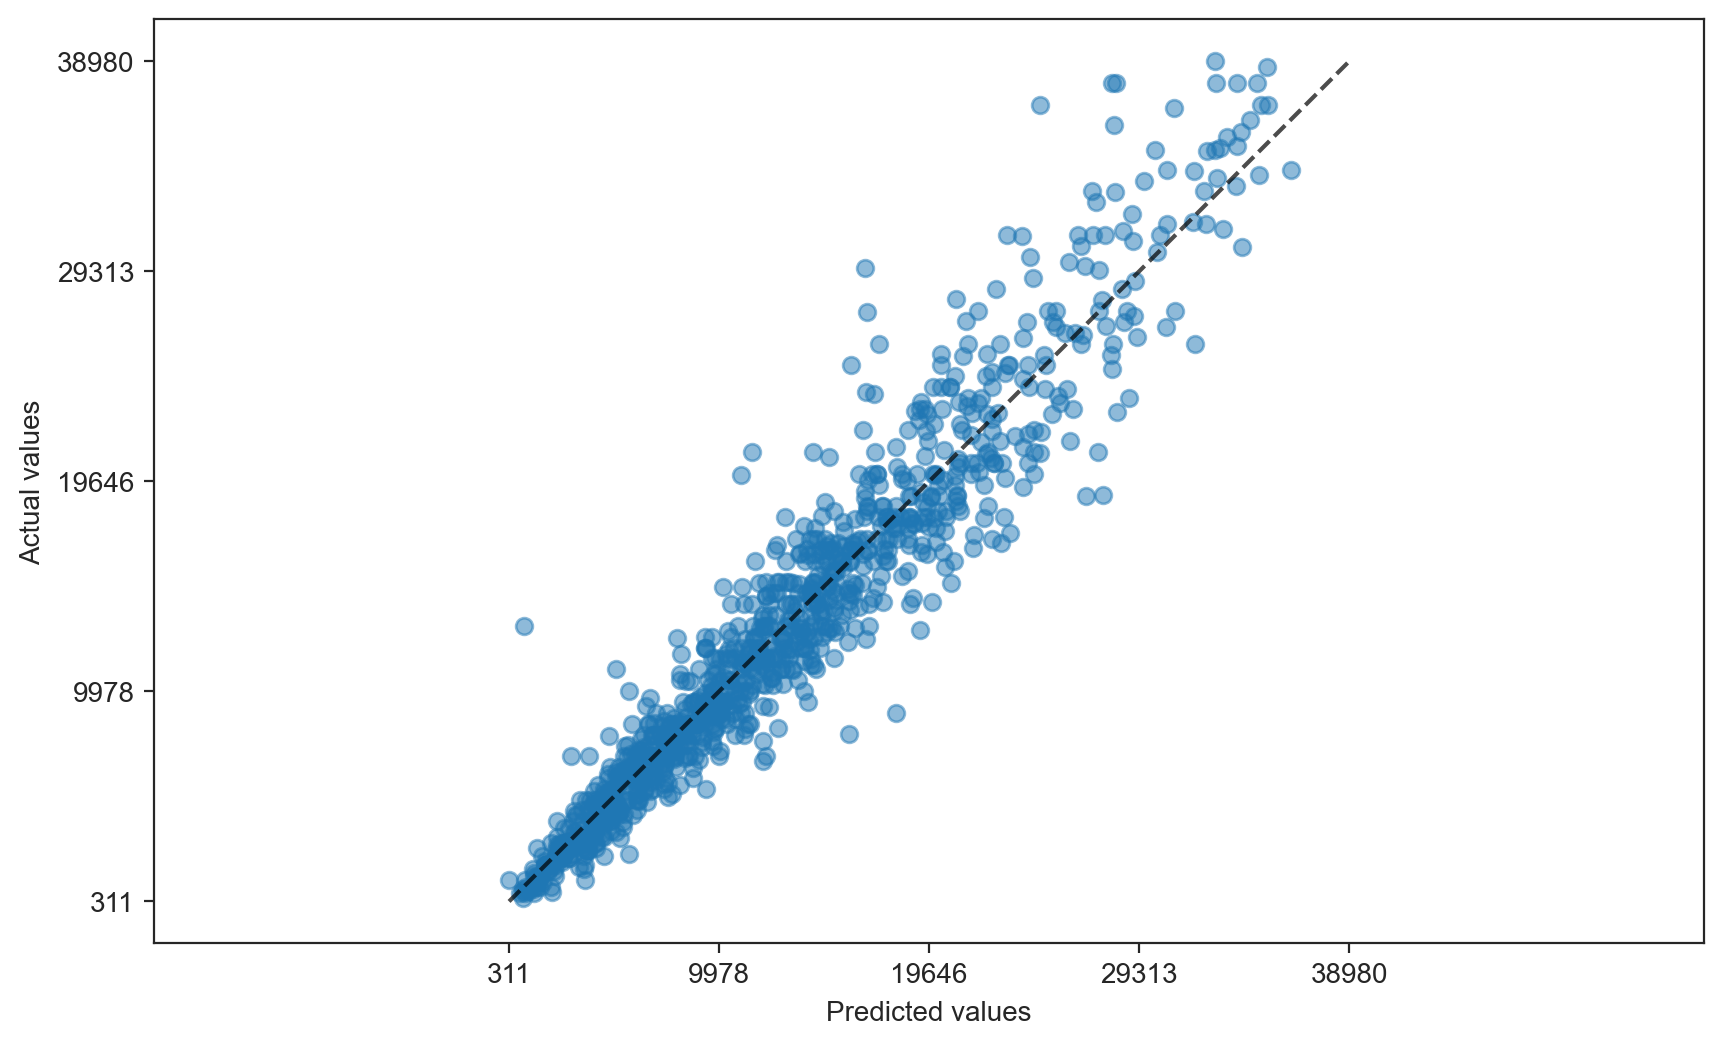

In [41]:
PredictionErrorDisplay.from_estimator(
    gbr.fit(X_train, y_train), X_test, y_test, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
)

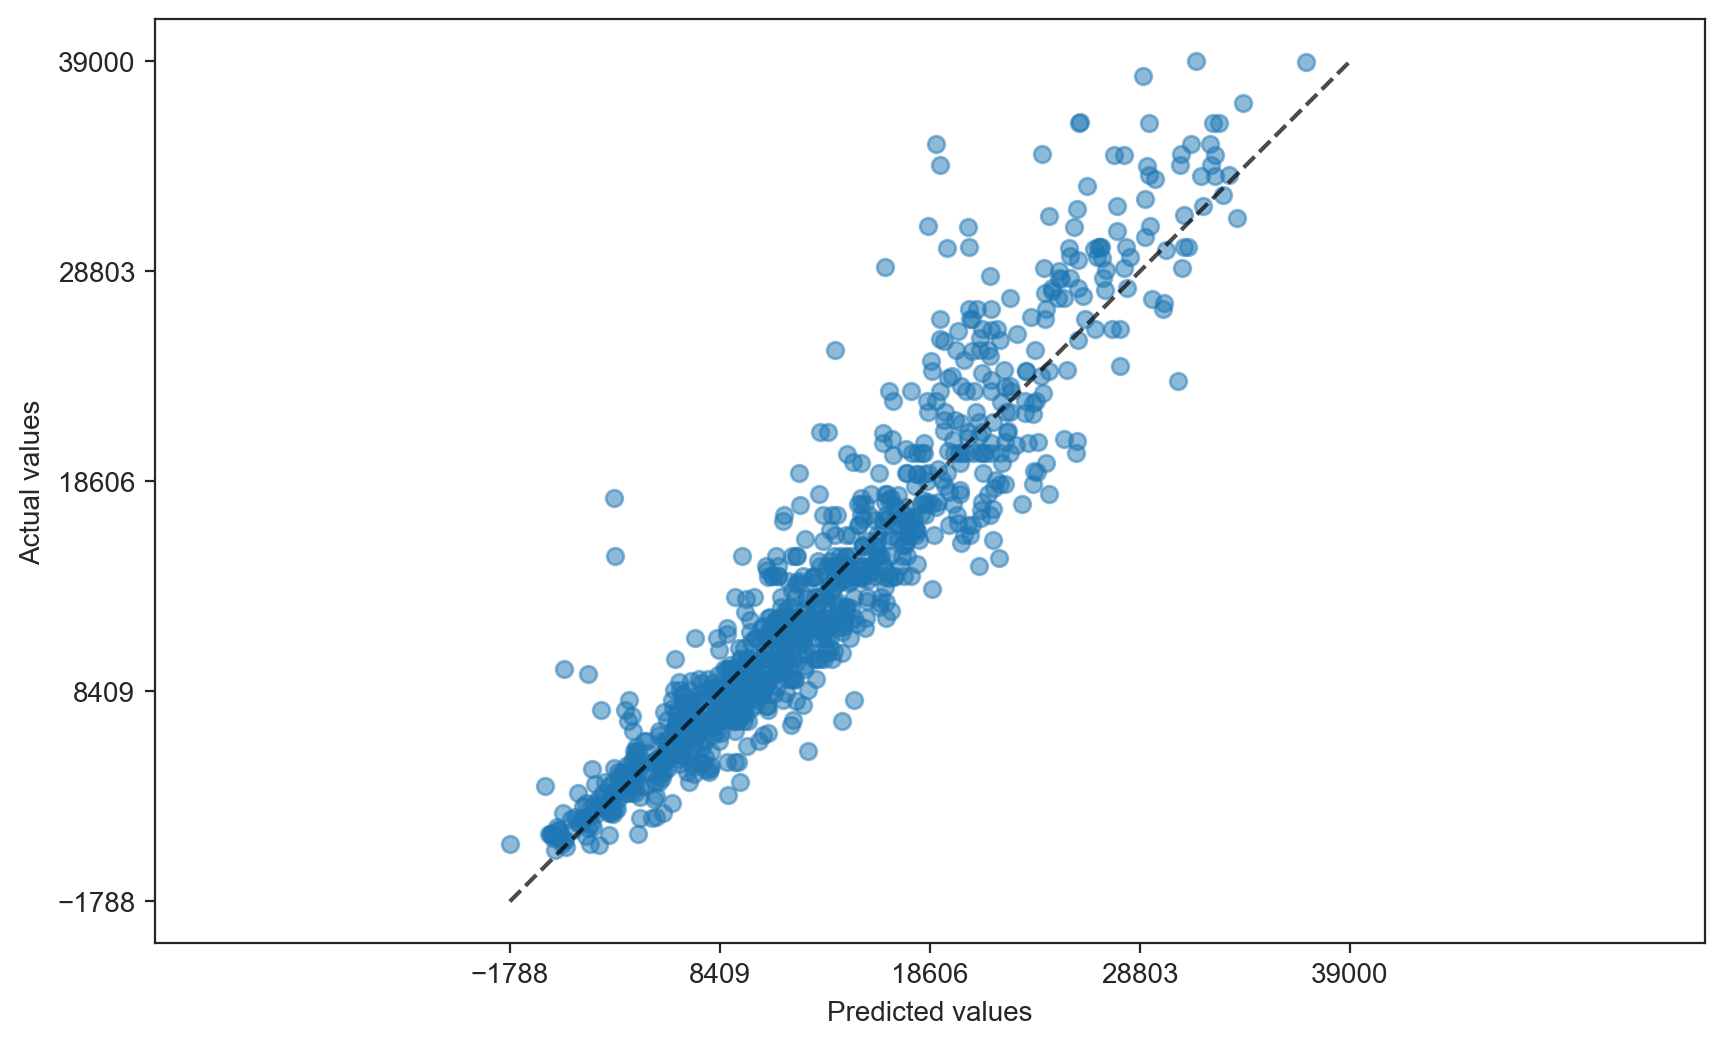

In [44]:
PredictionErrorDisplay.from_estimator(
    ensemble.fit(X_train, y_train), X_test, y_test, kind="actual_vs_predicted", scatter_kwargs=dict(alpha=0.5)
)

In [173]:
lr = create_pipeline(LinearRegression(), X_train)

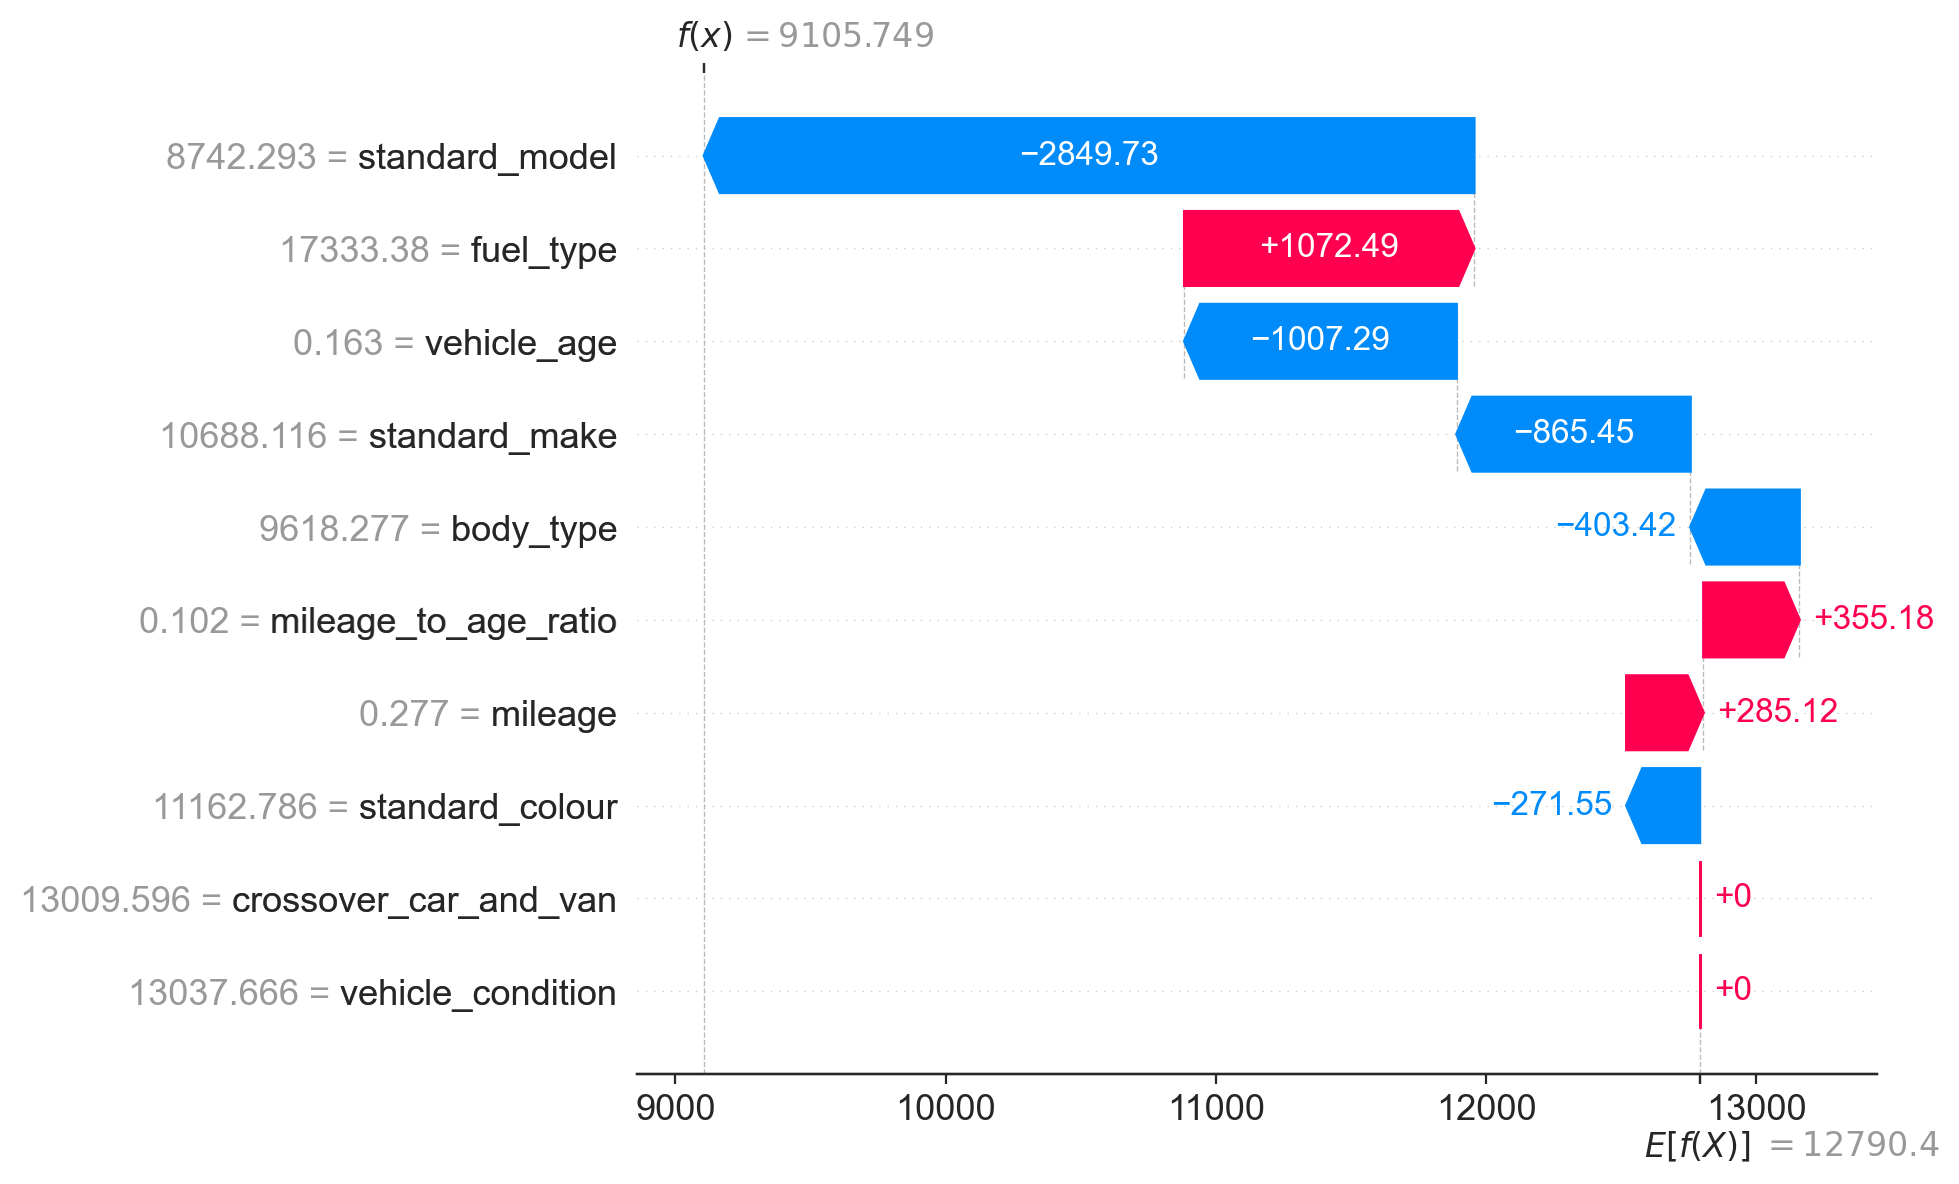

In [147]:
# Fit the pipeline
lr.fit(X_train, y_train)

# Transform the training and test data using the preprocessor from the pipeline
X_train_pp = lr.named_steps['preprocessor'].transform(X_train)
X_test_pp = lr.named_steps['preprocessor'].transform(X_test)

# Ensure the transformed data is a numpy array
X_train_pp = np.array(X_train_pp)
X_test_pp = np.array(X_test_pp)

# Get feature names after preprocessing
column_names = lr.named_steps['preprocessor'].get_feature_names_out()

# Define the SHAP explainer using the fitted linear regression model
explainer = shap.Explainer(lr.named_steps['regressor'], X_train_pp)

# Compute SHAP values for the transformed test data
explanations = explainer(X_test_pp)

# Display a SHAP waterfall plot 
row_idx = 39
shap.plots.waterfall(shap.Explanation(values=explanations[row_idx].values,
                                      base_values=explanations[row_idx].base_values,
                                      data=X_test_pp[row_idx, :],  
                                      feature_names=column_names))


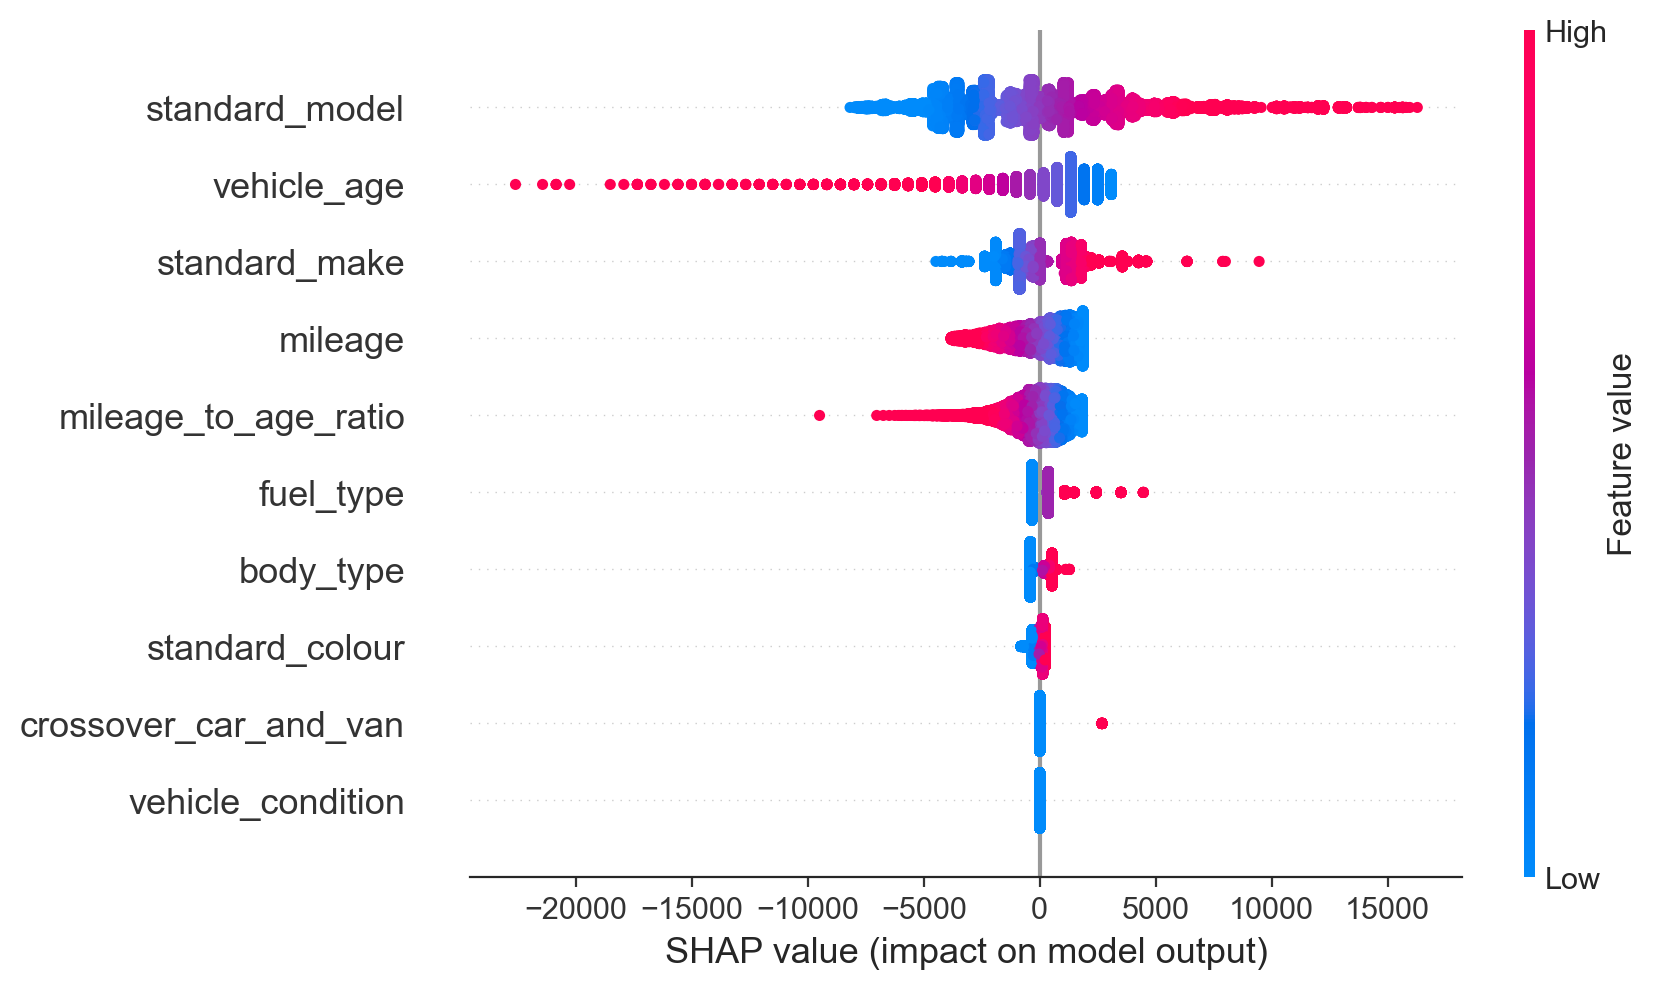

In [135]:
# Ensure base_values is a numpy array
base_values = np.array(explanations.base_values)

if base_values.ndim == 0:  
    base_values = np.repeat(base_values, explanations.values.shape[0])

# Convert all values to float explicitly
explanations_values = explanations.values.astype(float)
base_values = base_values.astype(float)

# Explicitly construct the SHAP Explanation object with float values
shap_expl = shap.Explanation(
    values=explanations_values,
    base_values=base_values,
    data=np.array(X_test_pp),
    feature_names=column_names
)

# Plot beeswarm plot with the correct base_values
shap.plots.beeswarm(shap_expl)

In [174]:
rfr = create_pipeline(RandomForestRegressor(max_depth=10, n_estimators=200), X_train)

100%|===================| 30884/30903 [26:21<00:00]        

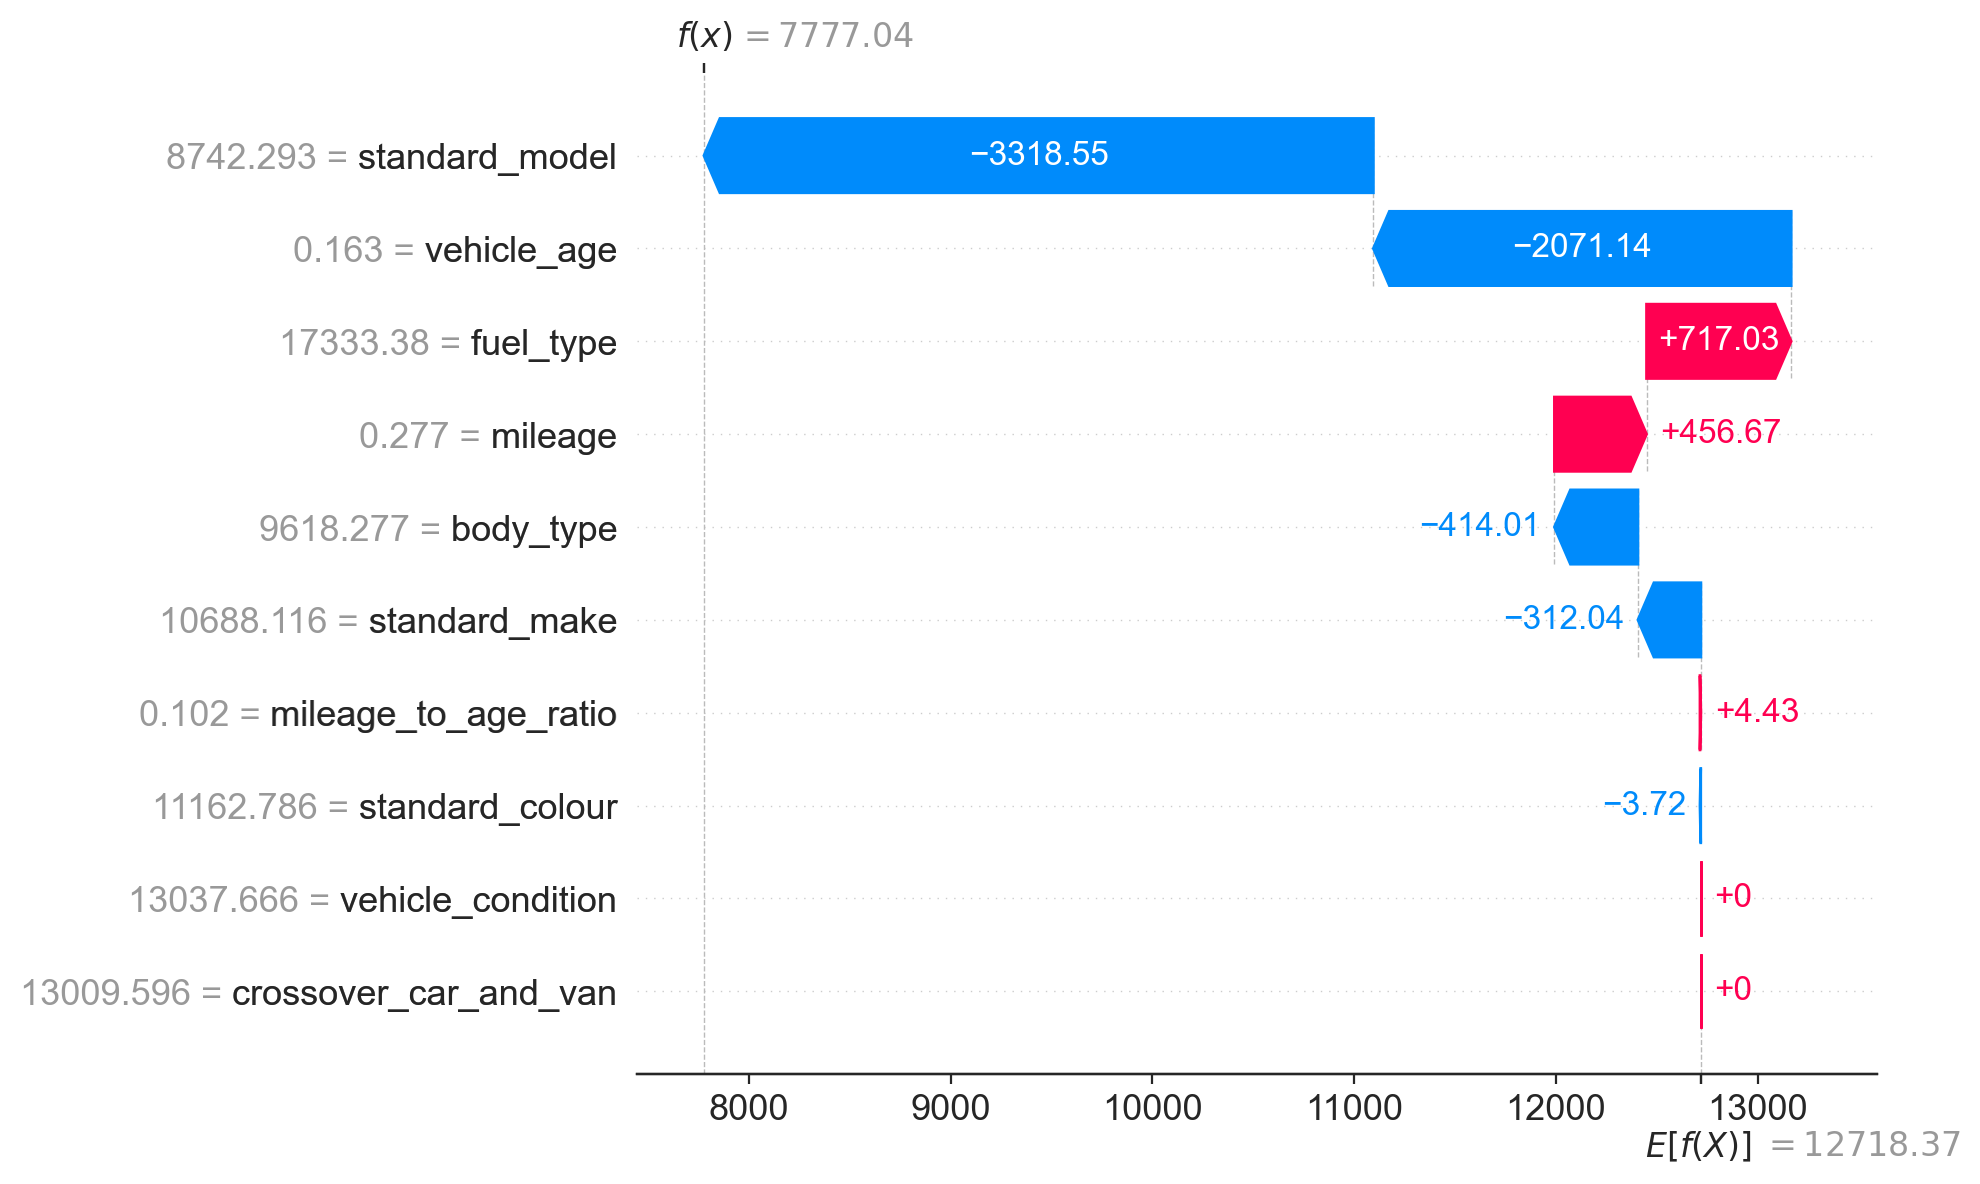

In [148]:
rfr.fit(X_train, y_train)

# Transform the training and test data using the preprocessor from the pipeline
X_train_pp_rf = rfr.named_steps['preprocessor'].transform(X_train)
X_test_pp_rf = rfr.named_steps['preprocessor'].transform(X_test)

# Ensure the transformed data is a numpy array and of type float
X_train_pp_rf = np.array(X_train_pp_rf, dtype=float)
X_test_pp_rf = np.array(X_test_pp_rf, dtype=float)

# Get feature names after preprocessing
column_names = rfr.named_steps['preprocessor'].get_feature_names_out()

# Define the SHAP explainer using the fitted random forest regressor 
explainer_rf = shap.Explainer(rfr.named_steps['regressor'], X_train_pp_rf, feature_perturbation="interventional")

# Compute SHAP values 
explanations_rf = explainer_rf(X_test_pp_rf, check_additivity=False)

# Display a SHAP waterfall plot 
row_idx = 39
shap.plots.waterfall(shap.Explanation(
    values=explanations_rf[row_idx].values,
    base_values=explanations_rf[row_idx].base_values,
    data=X_test_pp_rf[row_idx, :],
    feature_names=column_names
))

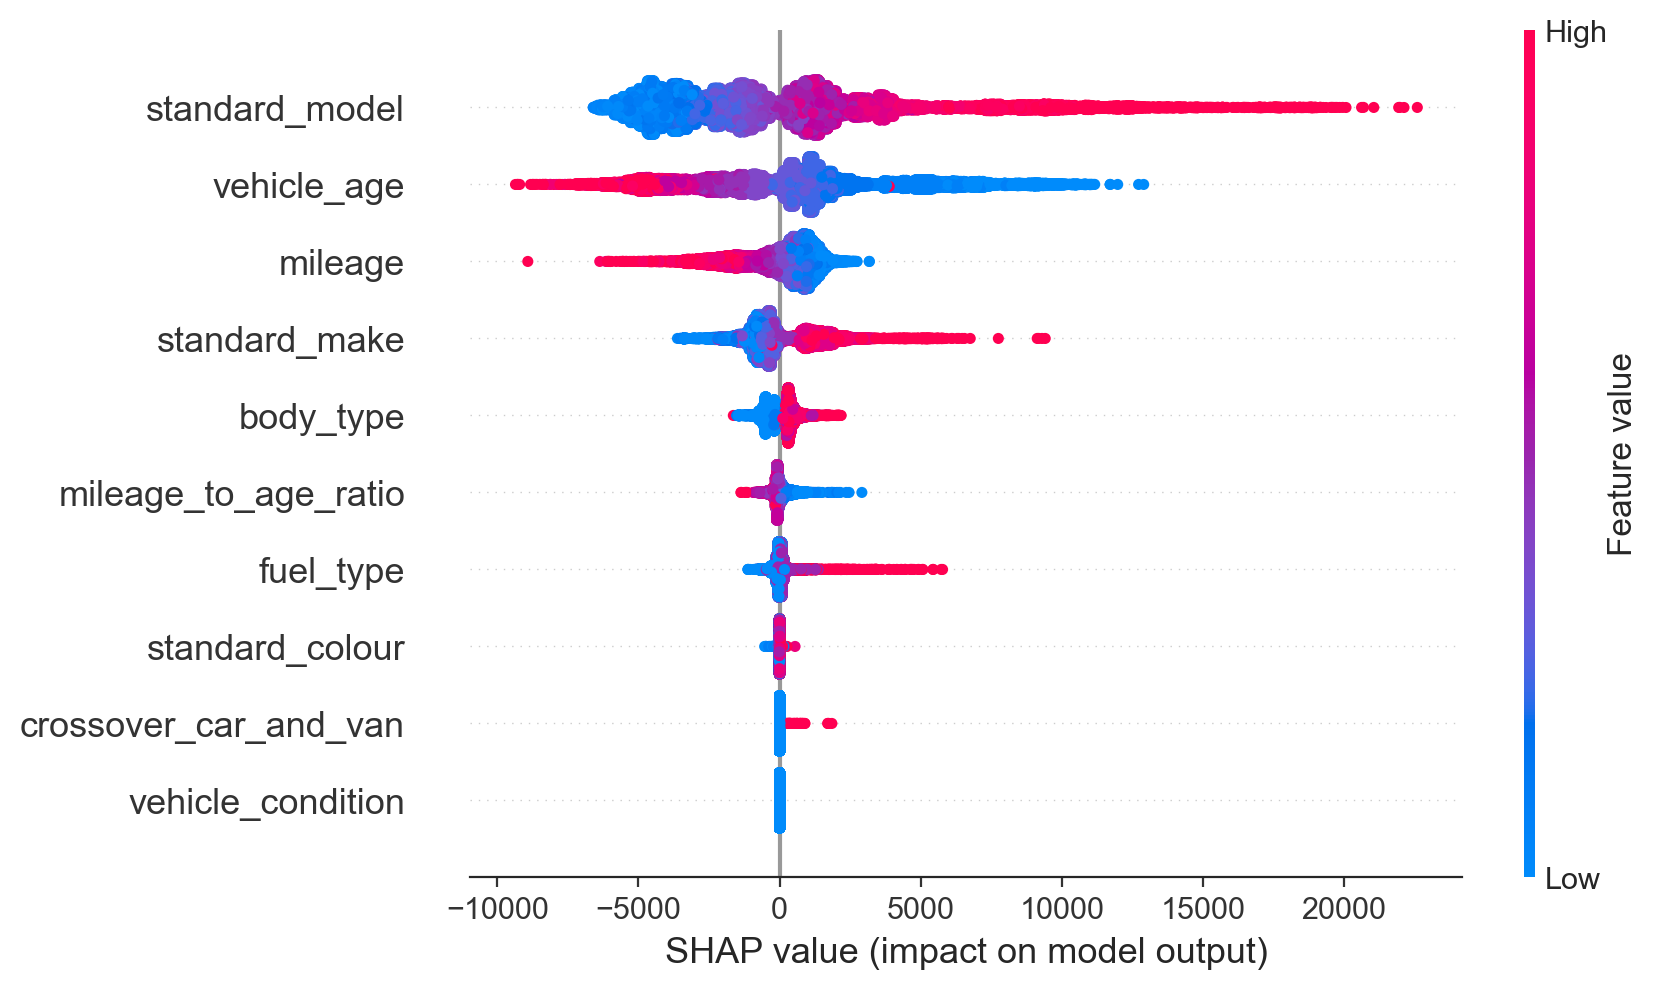

In [138]:
# Ensure base_values is a numpy array
base_values_rf = np.array(explanations_rf.base_values)

# Check if base_values is a single float
if base_values_rf.ndim == 0:  
    base_values_rf = np.repeat(base_values_rf, explanations_rf.values.shape[0])

# Convert all values to float explicitly
explanations_values_rf_float = explanations_rf.values.astype(float)
base_values_rf_float = base_values_rf.astype(float)

# Explicitly construct the SHAP Explanation object with float values
shap_expl_rf = shap.Explanation(
    values=explanations_values_rf_float,
    base_values=base_values_rf_float,
    data=np.array(X_test_pp_rf),
    feature_names=column_names
)

# Plot beeswarm plot with the correct base_values
shap.plots.beeswarm(shap_expl_rf)

In [175]:
gbr = create_pipeline(GradientBoostingRegressor(max_depth=7, learning_rate=0.1), X_train)

100%|===================| 30840/30903 [04:10<00:00]        

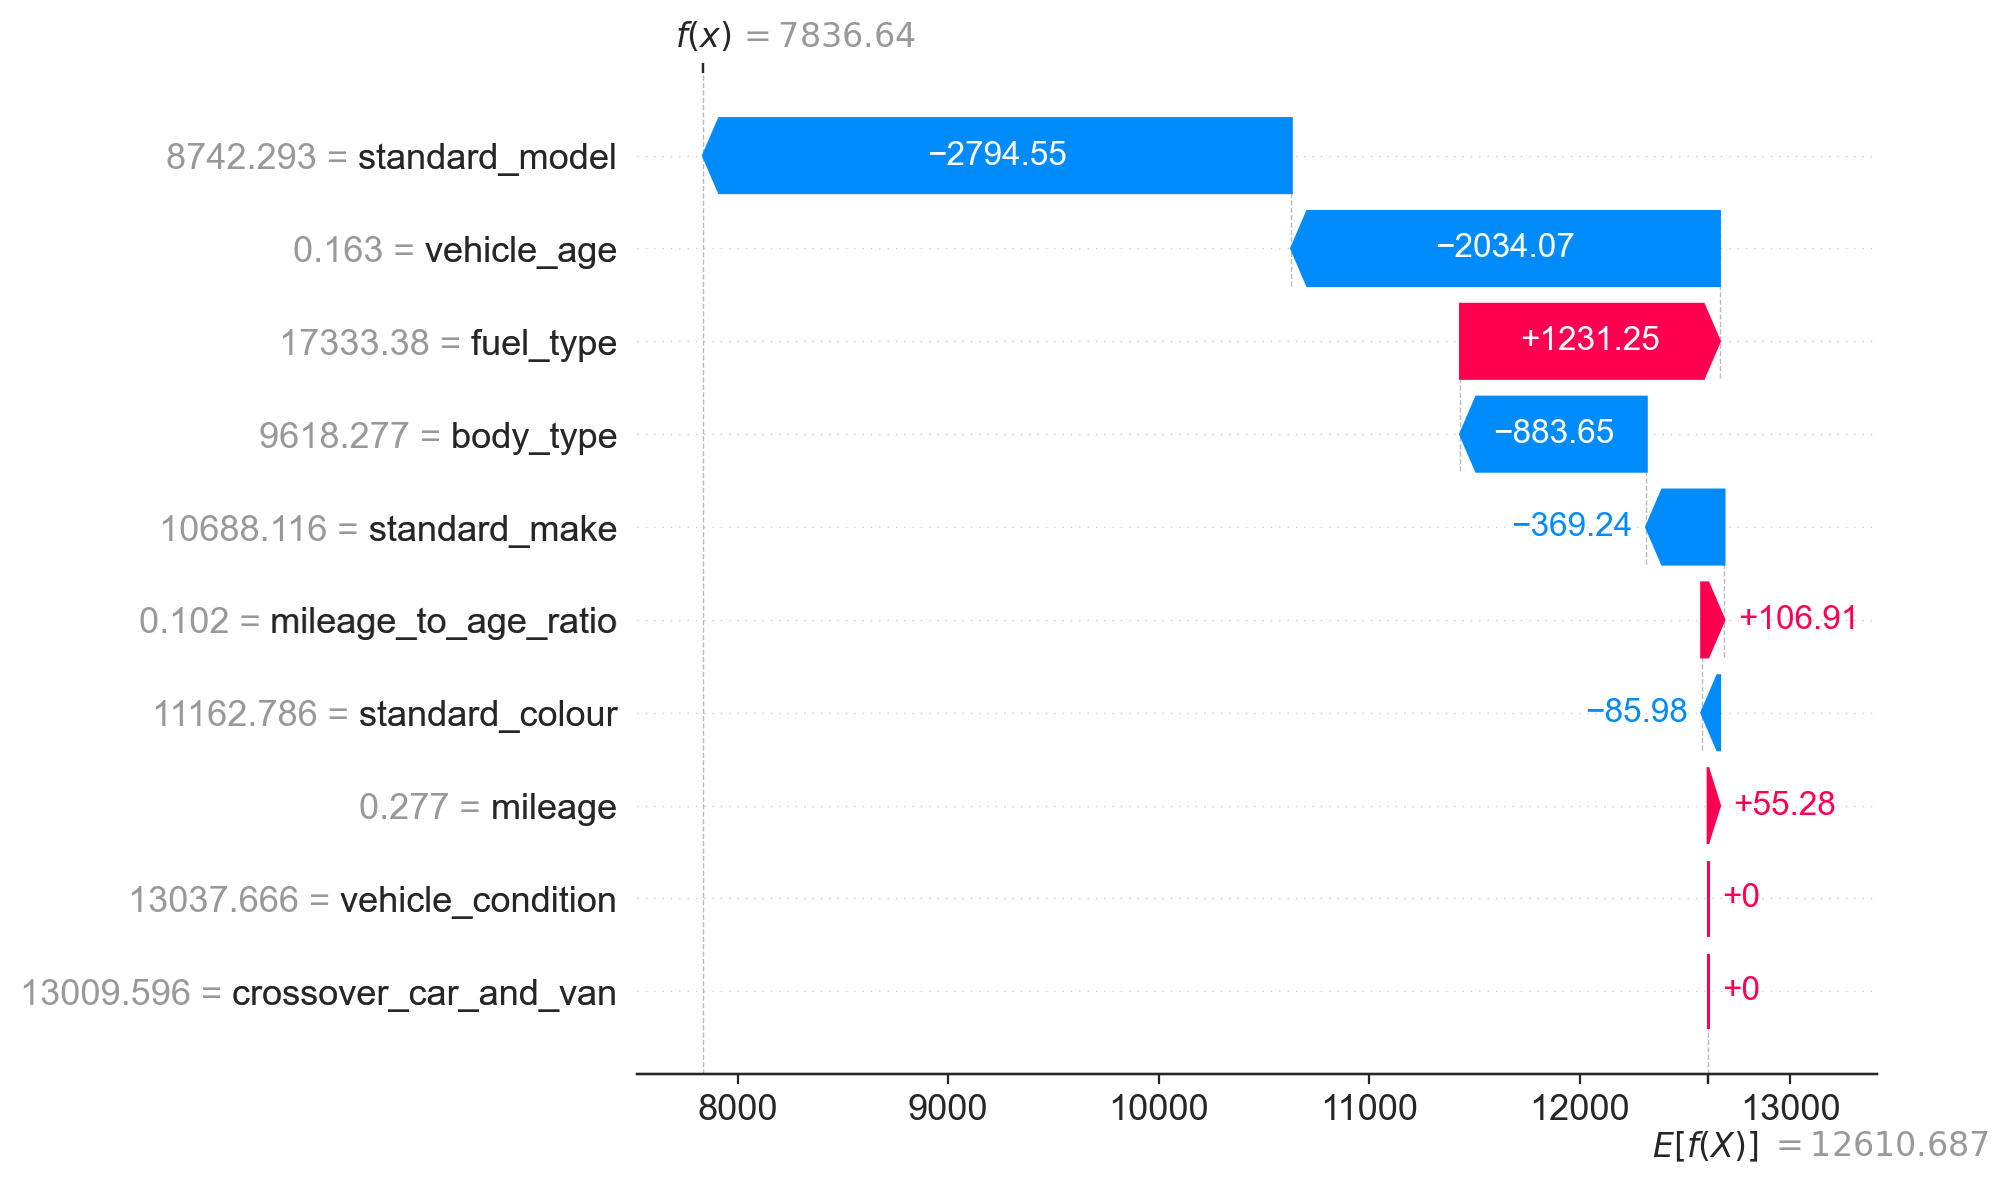

In [149]:
gbr.fit(X_train, y_train)

# Transform the training and test data using the preprocessor from the pipeline
X_train_pp_gb = gbr.named_steps['preprocessor'].transform(X_train)
X_test_pp_gb = gbr.named_steps['preprocessor'].transform(X_test)

# Ensure the transformed data is a numpy array and of type float
X_train_pp_gb = np.array(X_train_pp_gb, dtype=float)
X_test_pp_gb = np.array(X_test_pp_gb, dtype=float)

# Get feature names after preprocessing
column_names = gbr.named_steps['preprocessor'].get_feature_names_out()

# Define the SHAP explainer using the fitted Gradient Boost regressor
explainer_gb = shap.Explainer(gbr.named_steps['regressor'], X_train_pp_gb, feature_perturbation="interventional")

# Compute SHAP values for the transformed test data
explanations_gb = explainer_gb(X_test_pp_gb, check_additivity=False)

# Display a SHAP waterfall plot for the first prediction in the test dataset
row_idx = 39
shap.plots.waterfall(shap.Explanation(
    values=explanations_gb[row_idx].values,
    base_values=explanations_gb[row_idx].base_values,
    data=X_test_pp_gb[row_idx, :],
    feature_names=column_names
))

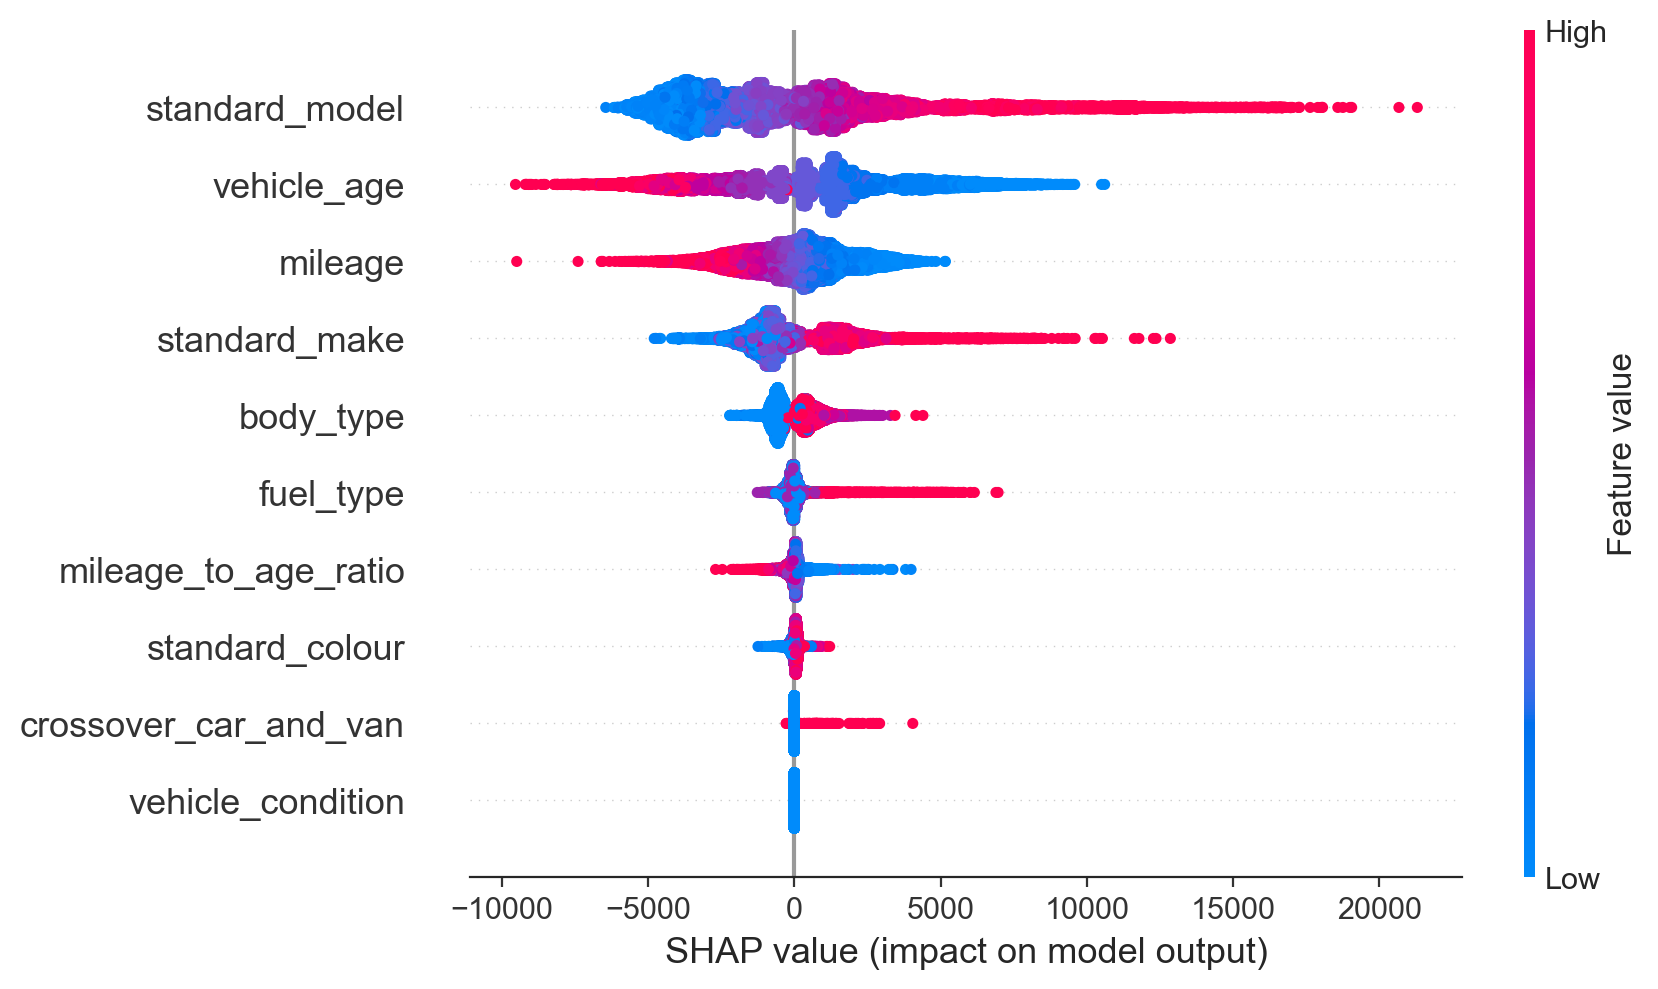

In [141]:
# Ensure base_values is a numpy array
base_values_gb = np.array(explanations_gb.base_values)

# Check if base_values is a single float 
if base_values_gb.ndim == 0:  
    base_values_gb = np.repeat(base_values_gb, explanations_gb.values.shape[0])

# Convert all values to float explicitly
explanations_values_gb_float = explanations_gb.values.astype(float)
base_values_gb_float = base_values_gb.astype(float)

# Explicitly construct the SHAP Explanation object with float values
shap_expl_gb = shap.Explanation(
    values=explanations_values_gb_float,
    base_values=base_values_gb_float,
    data=np.array(X_test_pp_gb),
    feature_names=column_names
)

# Plot beeswarm plot with the correct base_values
shap.plots.beeswarm(shap_expl_gb)

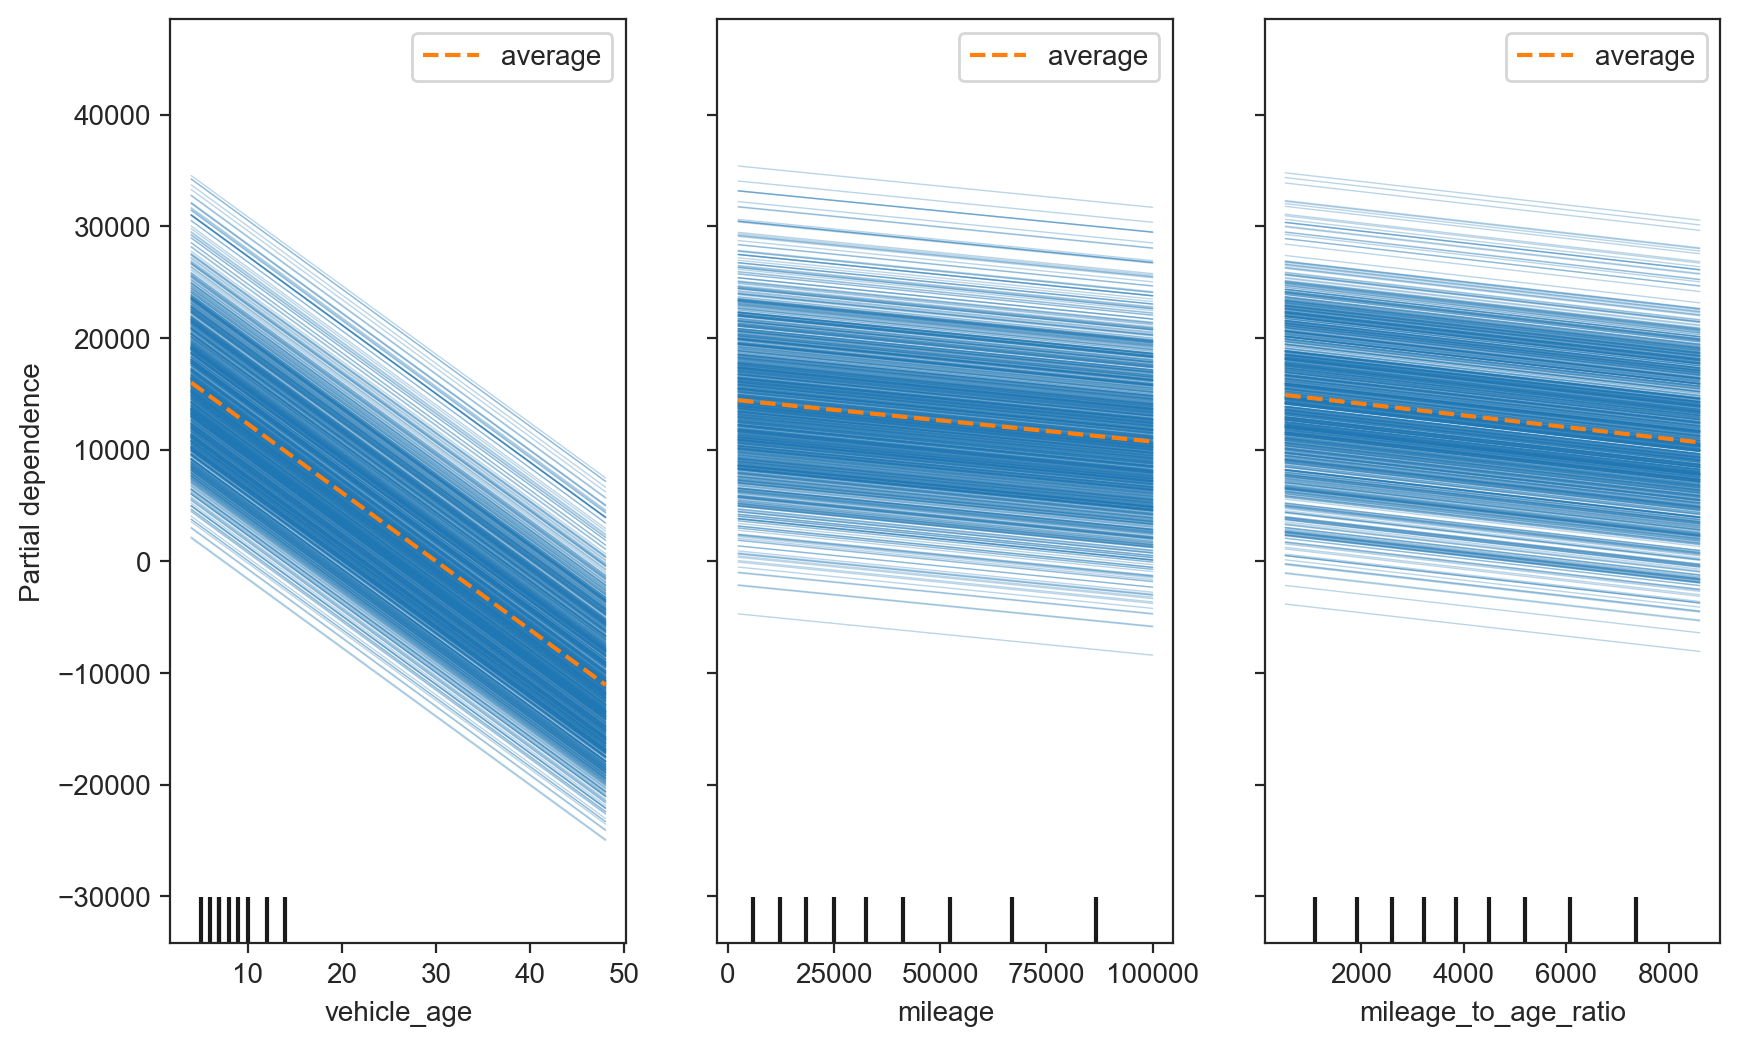

In [176]:
PartialDependenceDisplay.from_estimator(
    lr.fit(X_train,y_train), X_test, features=['vehicle_age', 'mileage', 'mileage_to_age_ratio'], kind='both'
);

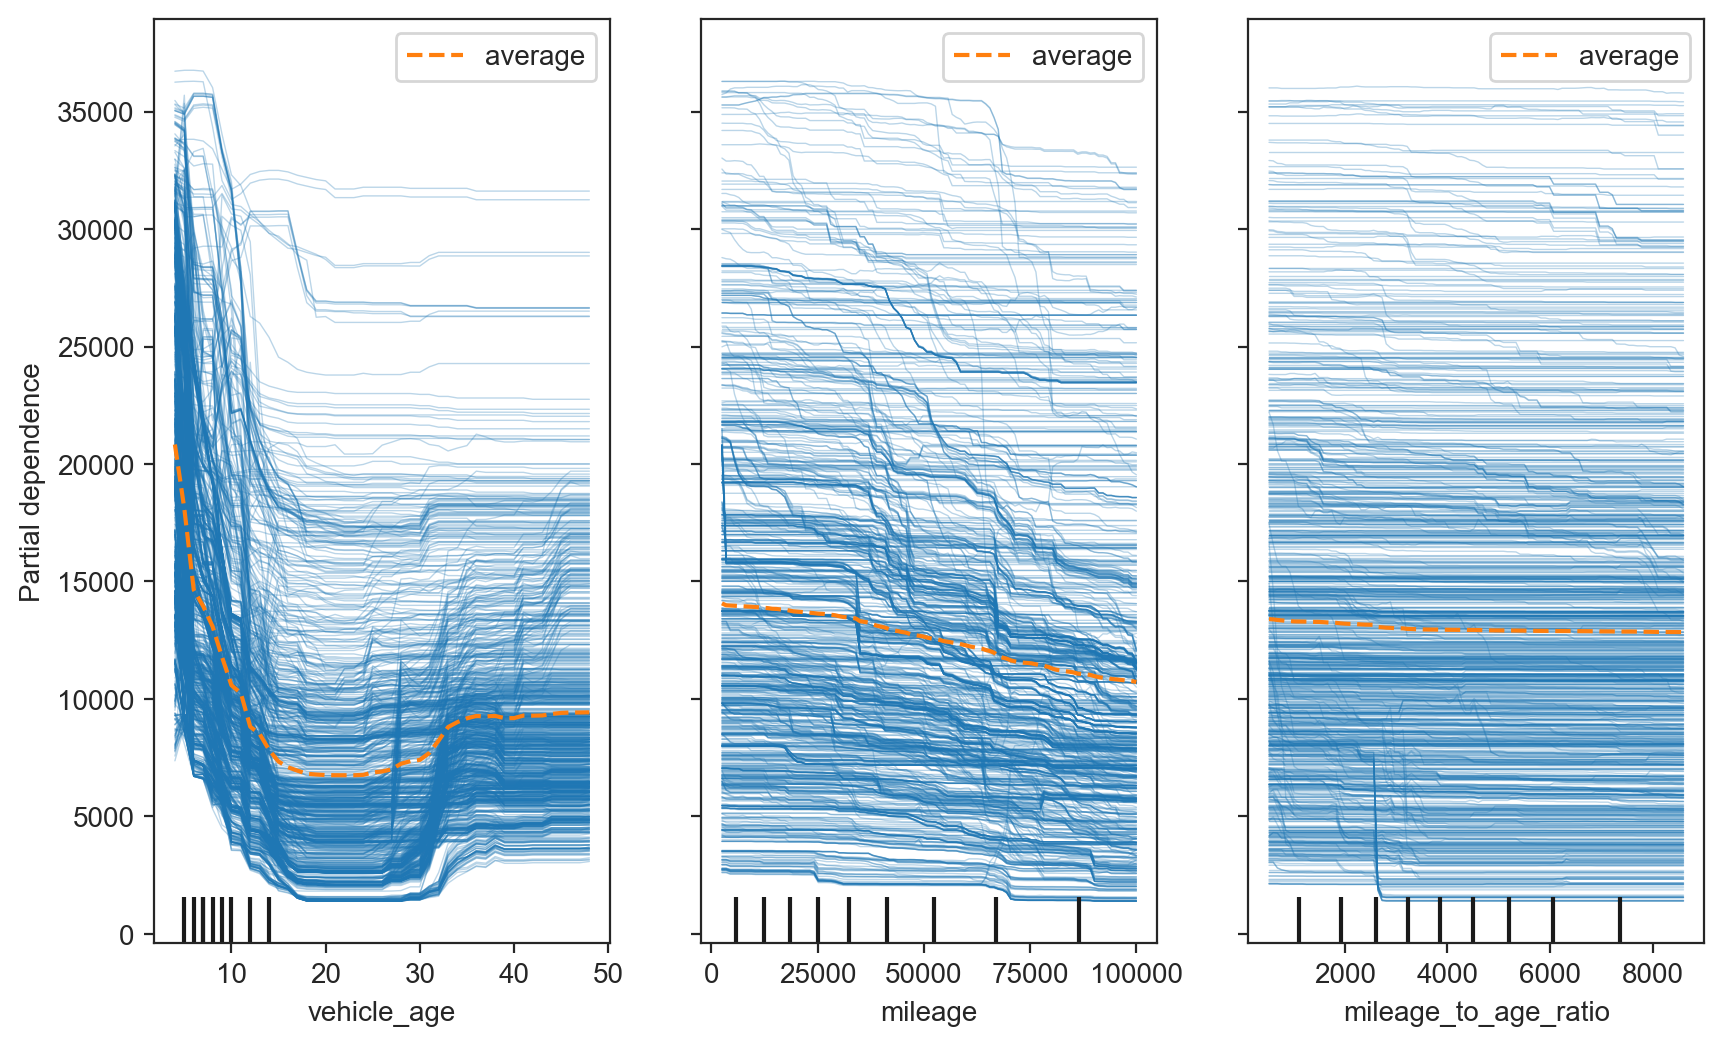

In [177]:
PartialDependenceDisplay.from_estimator(
    rfr.fit(X_train,y_train), X_test, features=['vehicle_age','mileage', 'mileage_to_age_ratio'], kind='both'
);

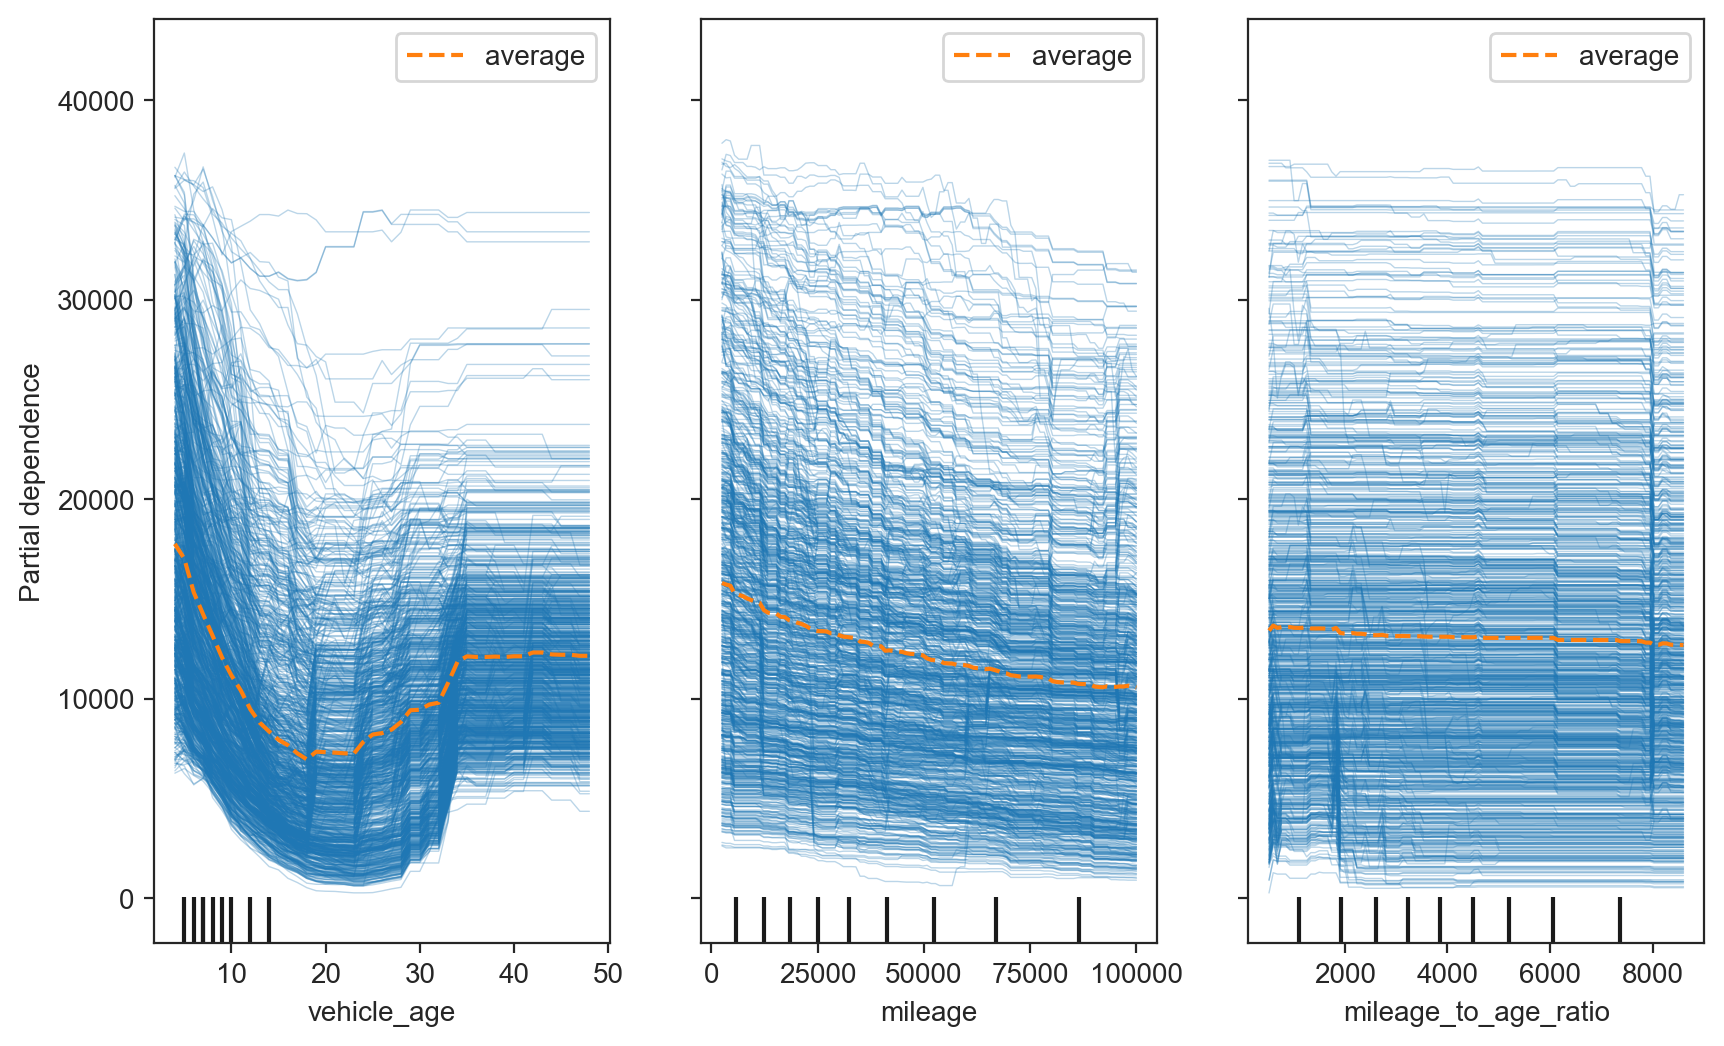

In [178]:
PartialDependenceDisplay.from_estimator(
    gbr.fit(X_train,y_train), X_test, features=['vehicle_age', 'mileage', 'mileage_to_age_ratio'], kind='both'
);